In [1]:
import numpy as np
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

%matplotlib inline

In [2]:
def show_results(*args):
    
    best_objective_value, best_chromosome, history_objective_values, history_best_chromosome, history_best_sigmas = args
    
    plt.figure(figsize=(18, 4))
    plt.plot(history_objective_values[:, 0], 'r-', label='minimum') # min
    plt.plot(history_objective_values[:, 1], 'g-', label='maximum') # max
    plt.plot(history_objective_values[:, 2], 'b-', label='mean') # mean
    plt.xlabel('iteration')
    plt.ylabel('objective function value')
    plt.title('min/avg/max objective function values')
    plt.show()

    plt.figure(figsize=(18, 4))
    plt.plot(history_best_sigmas, 'r-')
    plt.xlabel('iteration')
    plt.ylabel('sigma value')
    plt.title('best sigmas')
    plt.show()

In [144]:
a= np.array([[1,2,3], [5,6,7], [1,6,2]])

print((a > np.array([1,1,1])))
#print(np.array([True, False, True]) and np.array([True, False, False]))
b = np.array([1,1])

b[np.array([0,0,1])] += 1
print(b)

[[False  True  True]
 [ True  True  True]
 [False  True  True]]
[2 2]


In [248]:
def NSGA_Rank(objective_values):
    #objective_values : criterion_num x ppl_size
    ppl_size = objective_values.shape[1]
    criterion_num = objective_values.shape[0]
    
    Nx = np.zeros(ppl_size)
    Sx = np.zeros((ppl_size, ppl_size)) # (a,b) == 1  <=> a dominates b
    C_distx = np.zeros(ppl_size)
    
    for i in range(ppl_size):
        worse_or_equal = (objective_values >= objective_values[:,i,None]).all(axis=0)
        worse = (objective_values > objective_values[:,i,None]).any(axis=0)
        dominated = np.logical_and(worse_or_equal, worse)
        Nx[dominated] += 1
        Sx[i] = dominated.astype(float)
        
    pareto_fronts = []
    while (Nx >= 0).any():
        pareto_front = (Nx==0).nonzero()[0]
        pareto_fronts.append(pareto_front)
        Nx[pareto_front] -= 1
        
        dominated = Sx[pareto_front, :].nonzero()[1]
        for j in dominated:
            Nx[j] -= 1
    
    if False:
        plt.figure(figsize=(10,16))
        plt.plot(objective_values[0,:], objective_values[1,:], 'ro')
        plt.show()
        print('********************** NEW PARETO **************************')
        for par_front in pareto_fronts:
            pareto_fronts_values = objective_values[:, par_front]
            plt.figure(figsize=(10,16))
            print(par_front)
            plt.plot(objective_values[0,:], objective_values[1,:], 'ro',
                     pareto_fronts_values[0,:], pareto_fronts_values[1,:], 'go'
                    )
            plt.show()
    
    for j in range(len(pareto_fronts)):
        for i in range(criterion_num):
            pareto_values = objective_values[i, pareto_fronts[j]]
            I = np.argsort(pareto_values)
            C_distx[I[0]] = 99999999
            C_distx[I[-1]] = 99999999
            for k in range(len(pareto_values)-2):
                better = pareto_values[I[k]]
                worse = pareto_values[I[k+2]]
                C_distx[I[k+1]] += worse - better
                
    
    ranking = []
    for j in range(len(pareto_fronts)):
        pareto_idx = pareto_fronts[j]
        I = np.argsort(C_distx[pareto_idx])[::-1]
        pareto_idx = pareto_idx[I]
        ranking.append(pareto_idx)
    
    return np.hstack(ranking)
    

def NSGA(objective_functions, chromosome_length, population_size, number_of_iterations, number_of_offspring,
       number_of_parents, sigma, tau, tau_0, log_frequency=1, min_domain=-100, max_domain=100,
         mutation_type='no_correl', log_function=None):
 
    criterion_num = len(objective_functions)
    
    pareto_fronts_solutions = []
    pareto_fronts_objectives = []

    log_best_sigmas = np.empty((number_of_iterations, chromosome_length))
    
    # generating an initial population
    current_population_solutions = np.random.uniform(min_domain, max_domain, 
                                                     size=(population_size, chromosome_length))
    
    current_population_sigmas = sigma * np.ones((population_size, chromosome_length))
    current_population_mats = sigma * np.ones((population_size, chromosome_length, chromosome_length))
    
    # evaluating the objective function on the current population
    current_population_objective_values = np.array([F(current_population_solutions) 
                                                    for F in objective_functions])

    for t in range(number_of_iterations):
        ranking = NSGA_Rank(current_population_objective_values)
        tournament_indicies = \
            np.random.randint(0, population_size, (number_of_offspring*number_of_parents, 2)) \
            .min(axis=1) \
            .reshape((number_of_offspring, number_of_parents)) 
    
        parent_indices = ranking[tournament_indicies]
        
        # creating the children population by Global Intermediere Recombination
        children_population_solutions = np.empty((number_of_offspring, chromosome_length))
        for i in range(number_of_offspring):
            children_population_solutions[i, :] = \
                current_population_solutions[parent_indices[i, :], :].mean(axis=0)
        
        # mutation
        if mutation_type=='no_correl':
            children_population_sigmas = np.empty((number_of_offspring, chromosome_length))
            for i in range(number_of_offspring):
                children_population_sigmas[i, :] = current_population_sigmas[parent_indices[i, :], :].mean(axis=0)
            
            children_population_sigmas *= np.exp(tau * np.random.randn(number_of_offspring, chromosome_length) 
                    + tau_0 * np.random.randn(number_of_offspring, 1))
            
            for i in range(number_of_offspring):
                children_population_solutions[i, :] += \
                    children_population_sigmas[i,:] * np.random.randn(chromosome_length)
                
        elif mutation_type=='correl':
            children_population_mats = np.empty((number_of_offspring, chromosome_length, chromosome_length))
            for i in range(number_of_offspring):
                children_population_mats[i,:,:] = current_population_mats[parent_indices[i, :],:,:].mean(axis=0)
            
            children_population_mats *= \
                np.exp(tau * np.random.randn(number_of_offspring, chromosome_length, chromosome_length) \
                + tau_0 * np.random.randn(number_of_offspring, 1, 1))
            
            for i in range(number_of_offspring):
                A = children_population_mats[i]
                covariance_mat = np.dot(A, A.T)
                children_population_solutions[i, :] += np.dot(
                    np.random.randn(1, chromosome_length), np.linalg.cholesky(covariance_mat).T)[0]
         
        # clip to domains
        children_population_solutions[children_population_solutions < min_domain] = min_domain
        children_population_solutions[children_population_solutions > max_domain] = max_domain
        
        # evaluating the objective function on the children population
        children_population_objective_values = np.array([F(children_population_solutions) 
                                                         for F in objective_functions])
        
        # replacing the current population by (Mu + Lambda) Replacement
        current_population_objective_values = \
            np.hstack([current_population_objective_values, children_population_objective_values])
        current_population_solutions = \
            np.vstack([current_population_solutions, children_population_solutions])
            
        if mutation_type=='no_correl':
            current_population_sigmas = np.vstack([current_population_sigmas, children_population_sigmas])
        elif mutation_type=='correl':
            current_population_mats = np.vstack([current_population_mats, children_population_mats])
        
        I = NSGA_Rank(current_population_objective_values)

        current_population_solutions = current_population_solutions[I[:population_size], :]
        current_population_objective_values = current_population_objective_values[:,I[:population_size]]
        
        pareto_fronts_solutions, pareto_fronts_values = current_population_solutions, current_population_objective_values
        
        if mutation_type=='no_correl':
            current_population_sigmas = current_population_sigmas[I[:population_size], :]
        elif mutation_type=='correl':
            current_population_mats = current_population_mats[I[:population_size]]
            
        if t % log_frequency == 0:
            print('Iteration: {:d}'.format(t))
            plt.figure(figsize=(10,16))
            plt.plot(current_population_objective_values[0,:], current_population_objective_values[1,:], 'go')#,
                    #children_population_objective_values[0,:], children_population_objective_values[1,:], 'ro')
            plt.show()
            
    return pareto_fronts_solutions, pareto_fronts_values

In [276]:
###########
#ZDT1
###########
def ZDT1f1(X):
    return X[:, 0]

def ZDT1f2(X):
    return g(X) * (1 - np.sqrt(X[:,0]/g(X)) )

###########
#ZDT2
###########
def ZDT2f1(X):
    return X[:, 0]

def ZDT2f2(X):
    return g(X) * (1 - (X[:,0]/g(X))**2 )

###########
#ZDT3
###########
def ZDT3f1(X):
    return X[:, 0]

def ZDT3f2(X):
    return g(X) * (1 - np.sqrt(X[:,0]/g(X)) - X[:,0]/g(X)*np.sin(np.pi*10*X[:,0]))
    
def g(X):
    d = X.shape[1]
    return 1 + 9.0*(X[:,1:].sum(axis=1))/(d-1)
    
###########
#FON
###########
def FONf1(X):
    return 1 - np.exp(
        -( (X - 1.0/np.sqrt(3.0))**2 ).sum(axis=1)
    )

def FONf2(X):
    return 1 - np.exp(
        -( (X + 1.0/np.sqrt(3.0))**2 ).sum(axis=1)
    )
    
###########
#SCH
###########
def SCHf1(X):
    return X[:,0]**2

def SCHf2(X):
    return (X[:,0]-2.0)**2

Iteration: 0


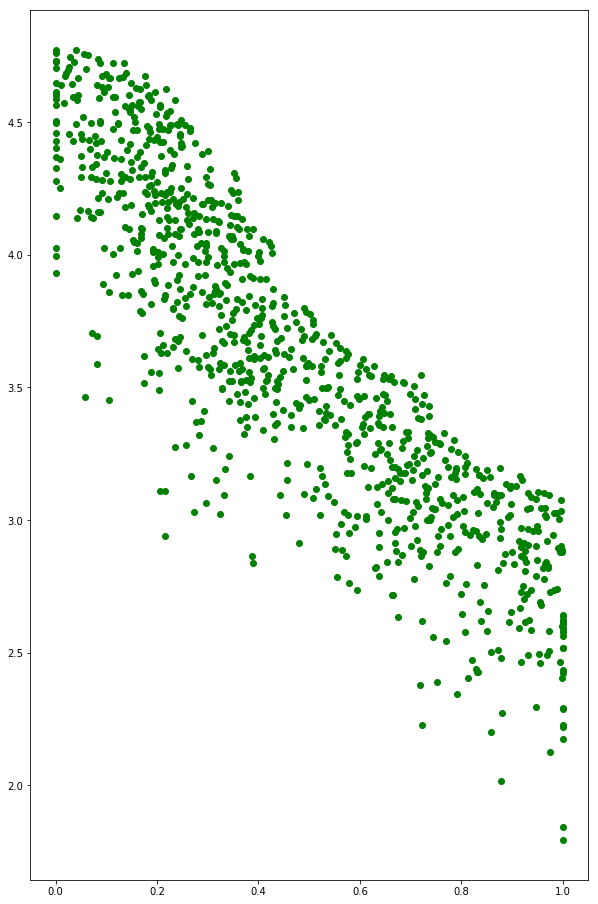

Iteration: 10


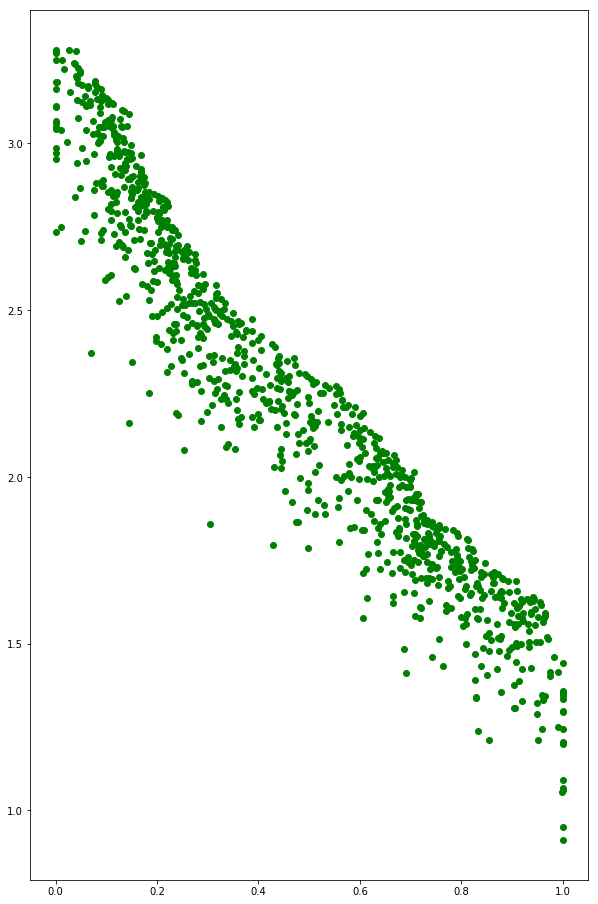

Iteration: 20


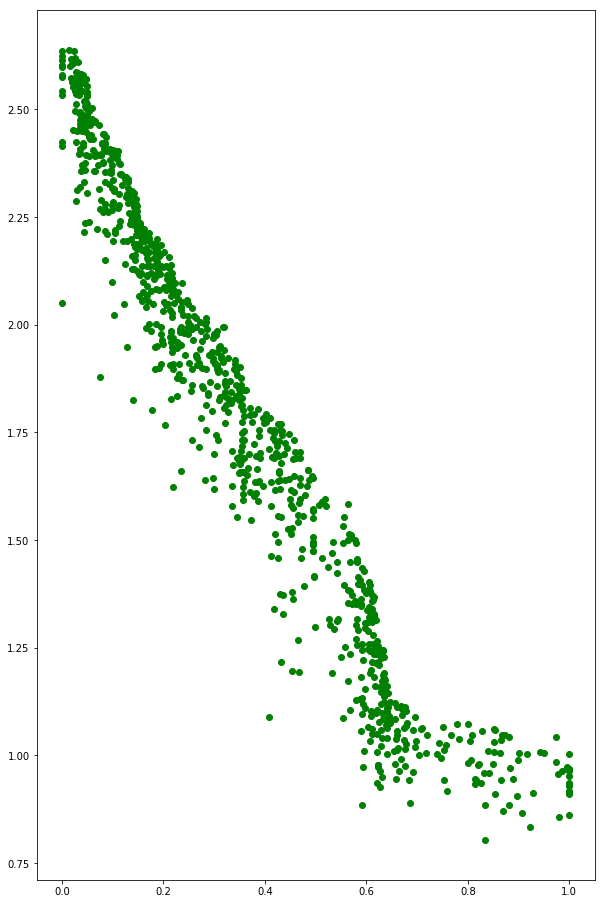

Iteration: 30


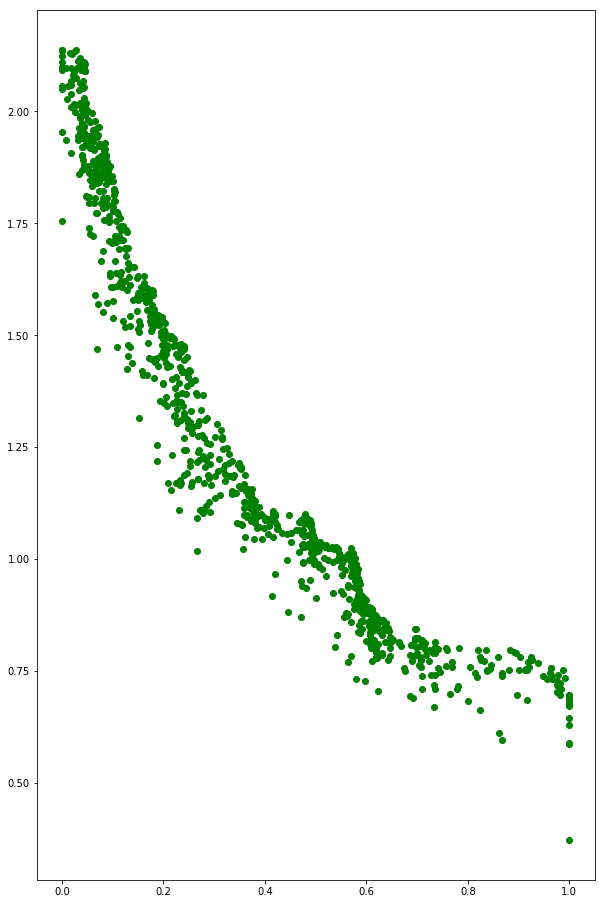

Iteration: 40


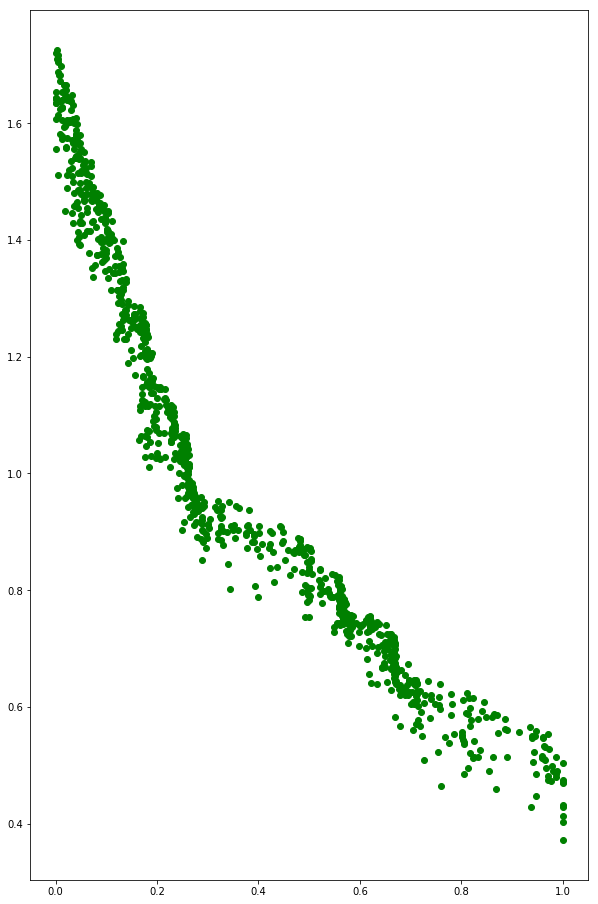

Iteration: 50


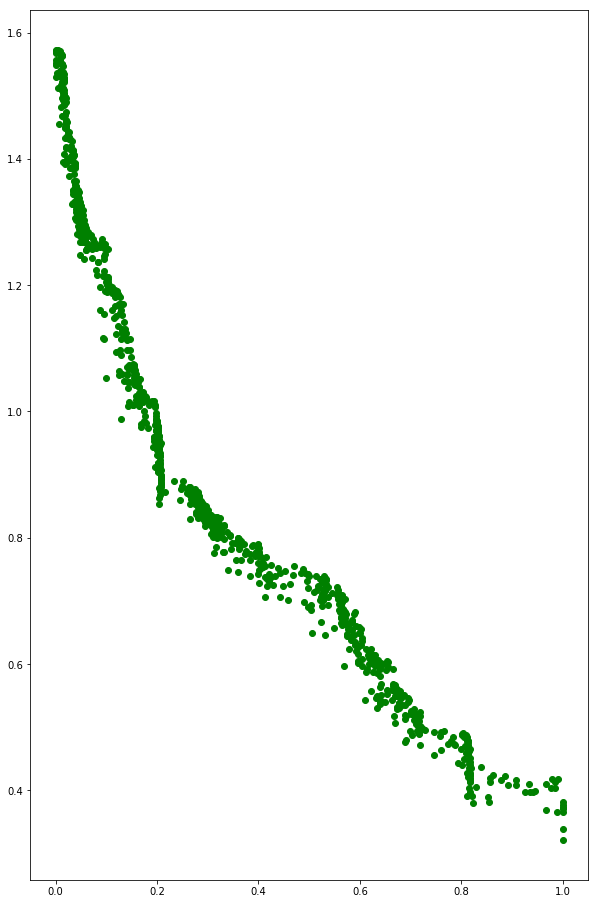

Iteration: 60


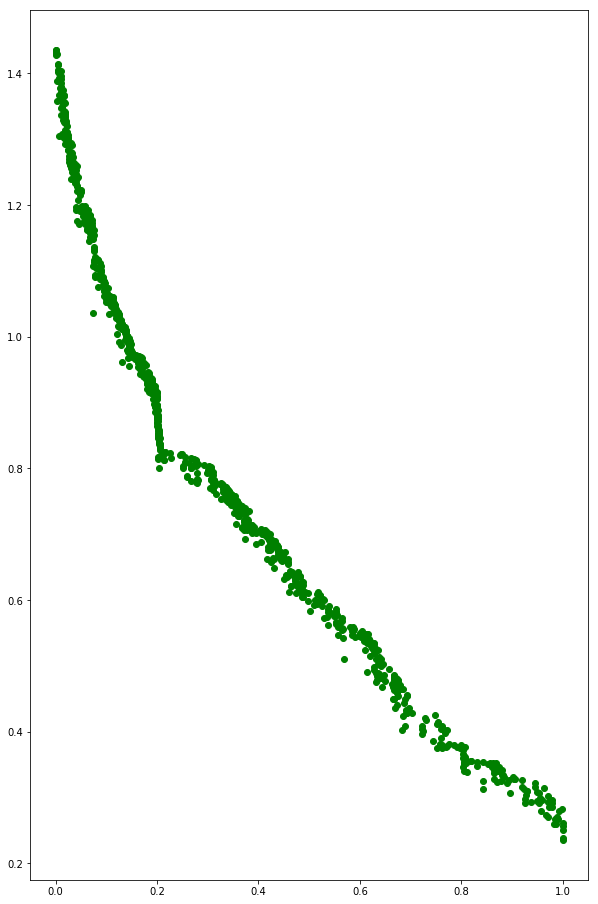

Iteration: 70


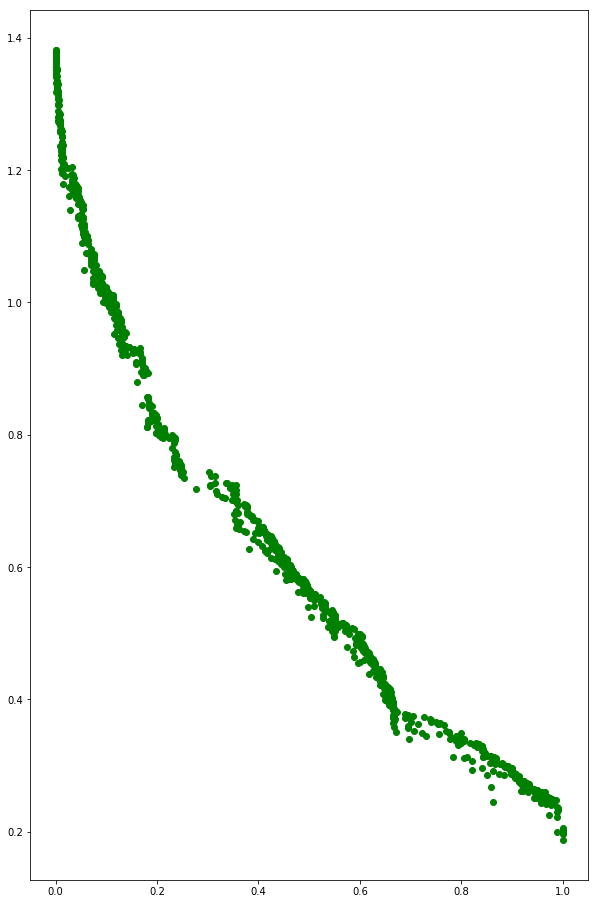

Iteration: 80


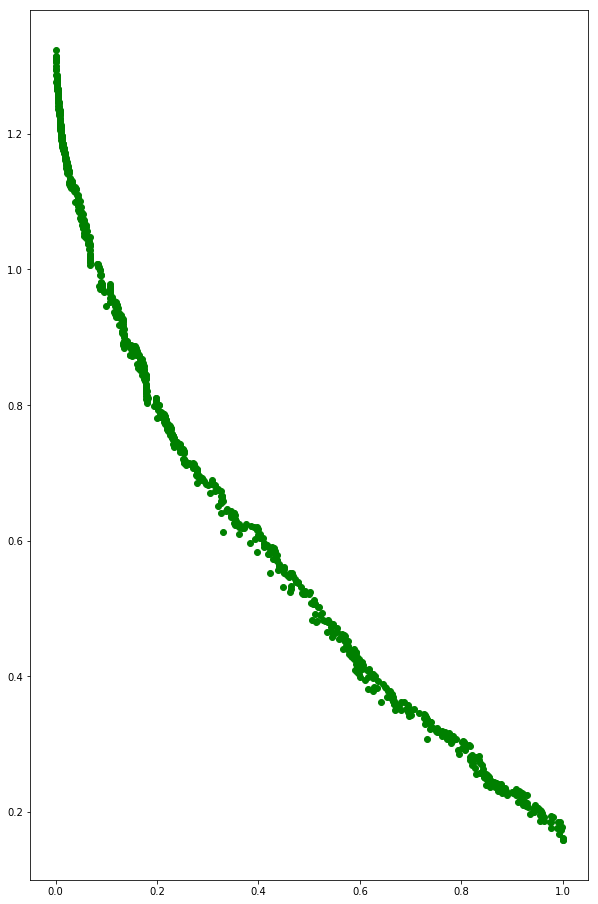

Iteration: 90


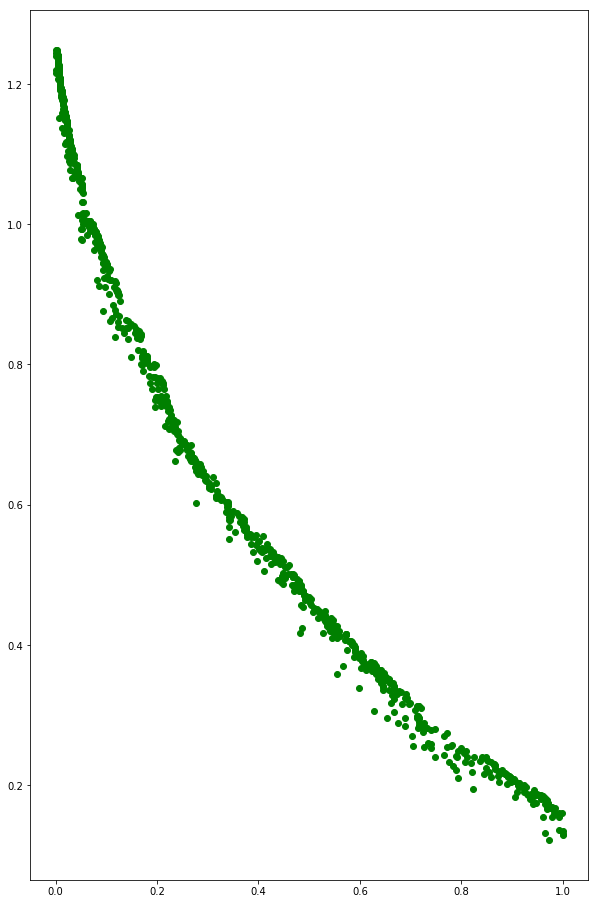

Iteration: 100


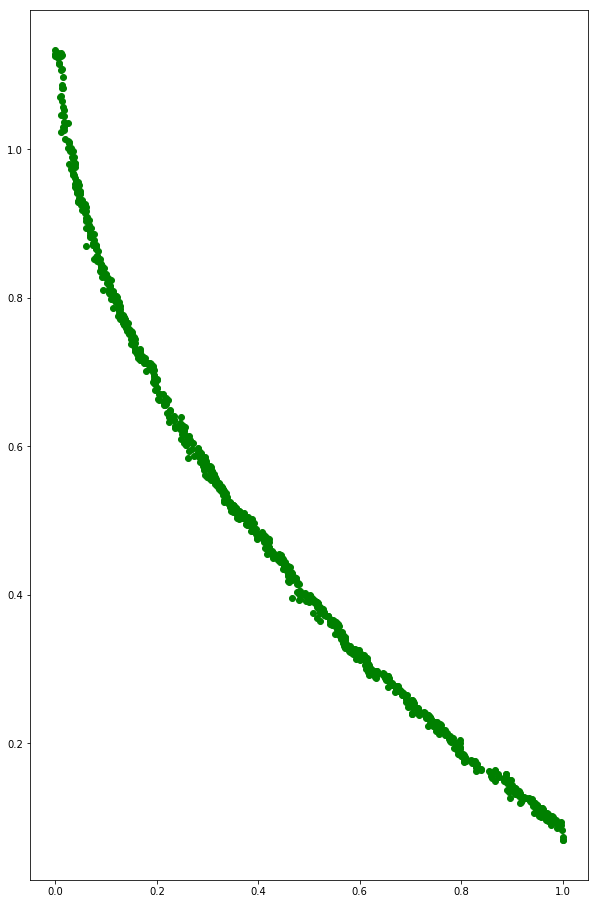

Iteration: 110


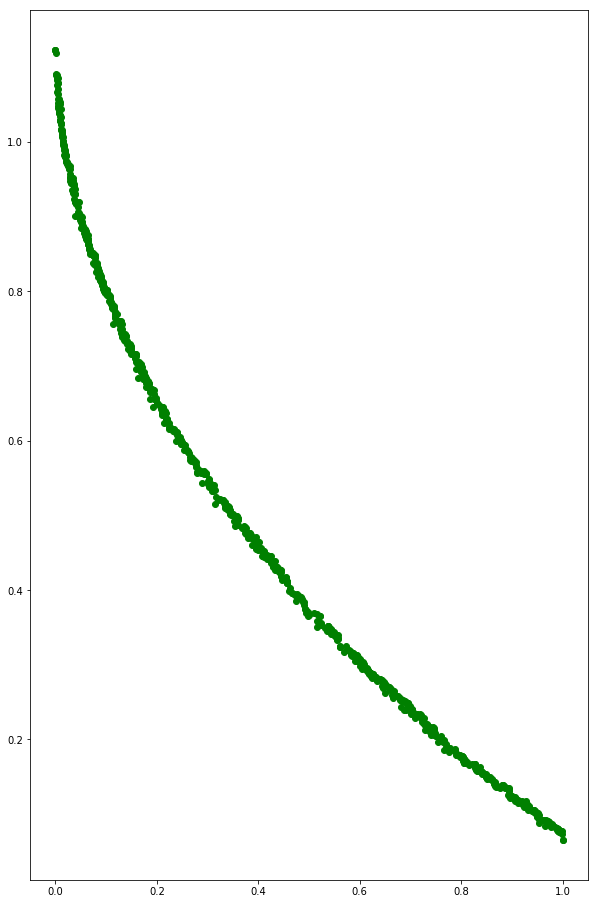

Iteration: 120


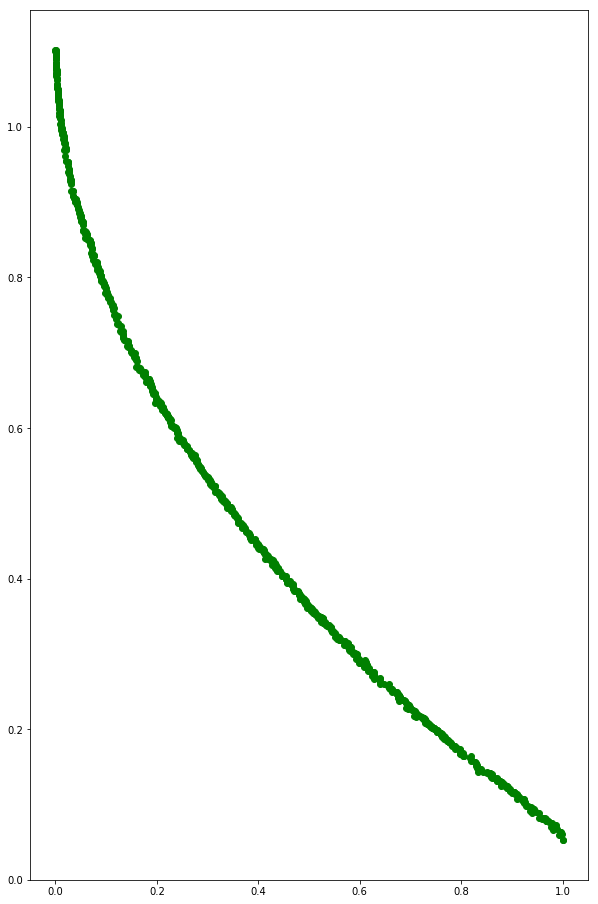

Iteration: 130


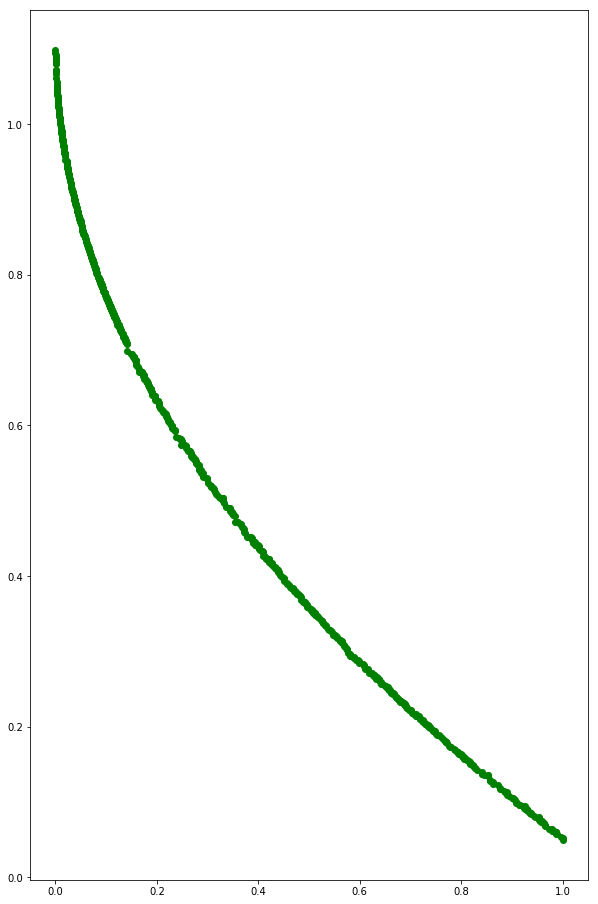

Iteration: 140


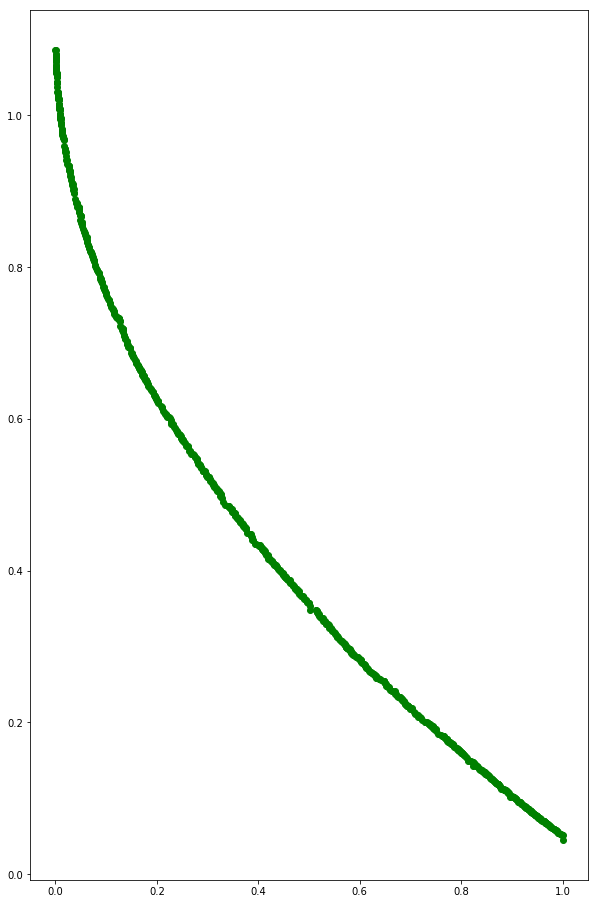

Iteration: 150


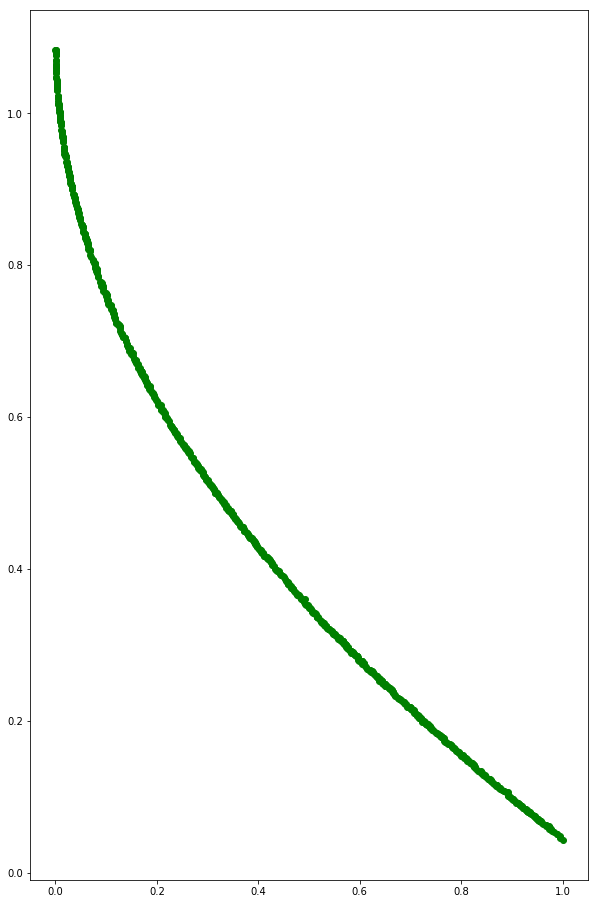

Iteration: 160


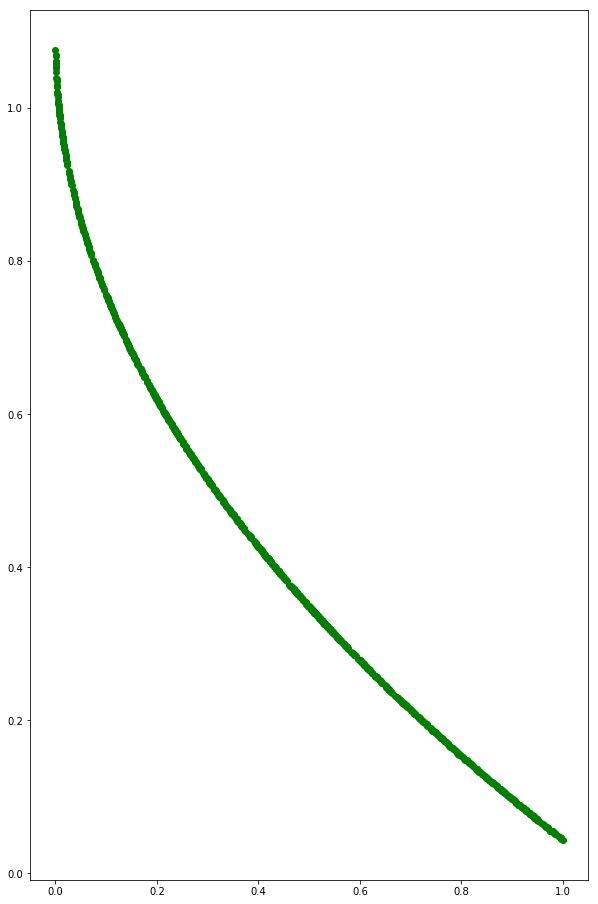

Iteration: 170


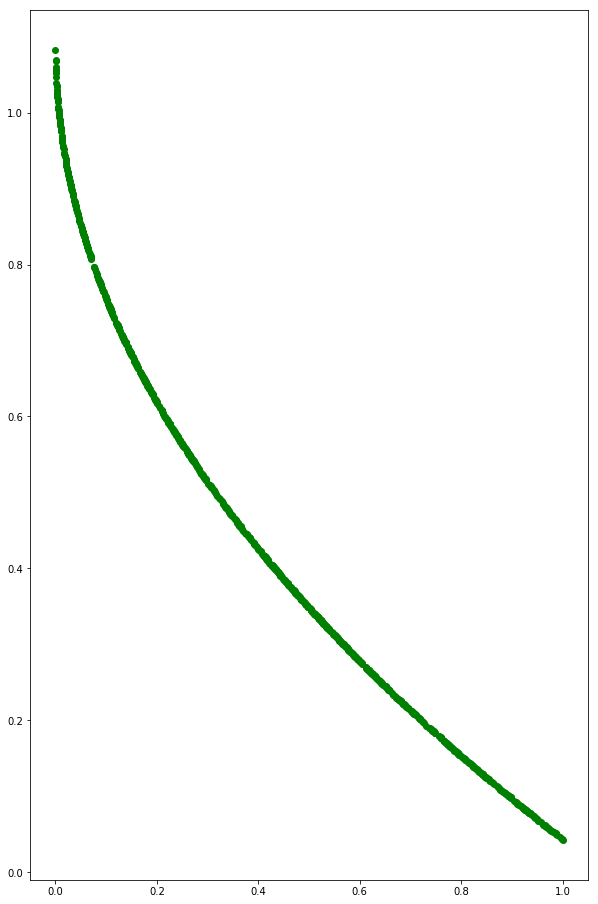

Iteration: 180


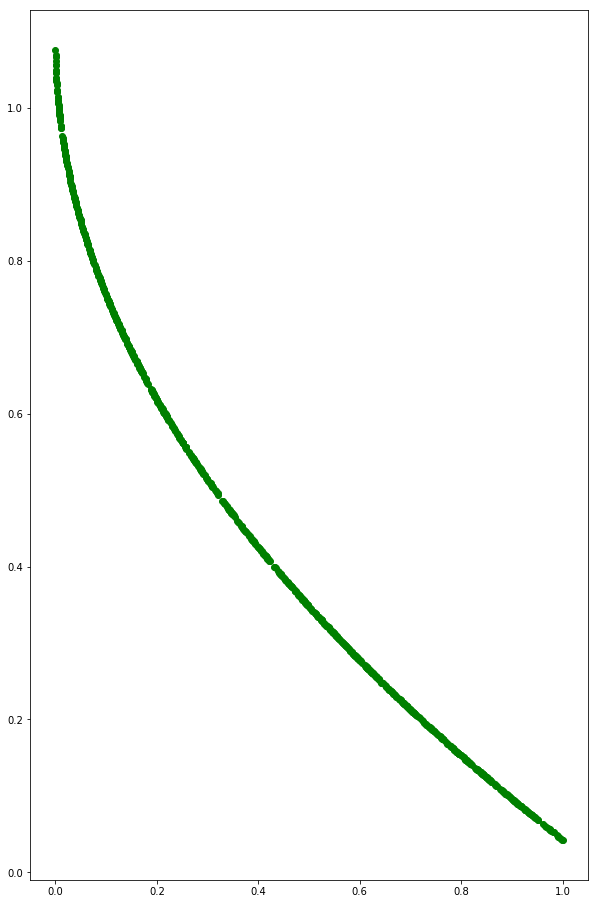

Iteration: 190


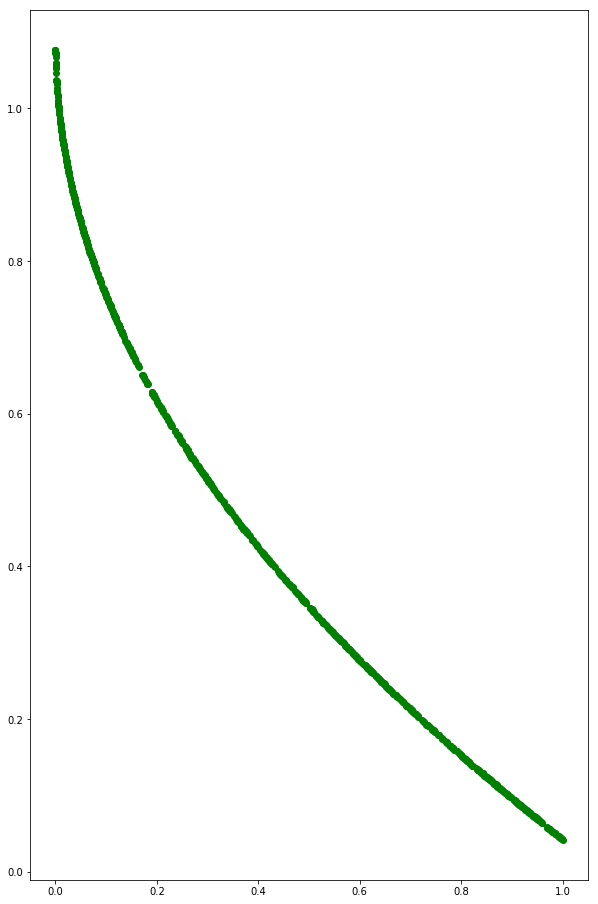

Iteration: 200


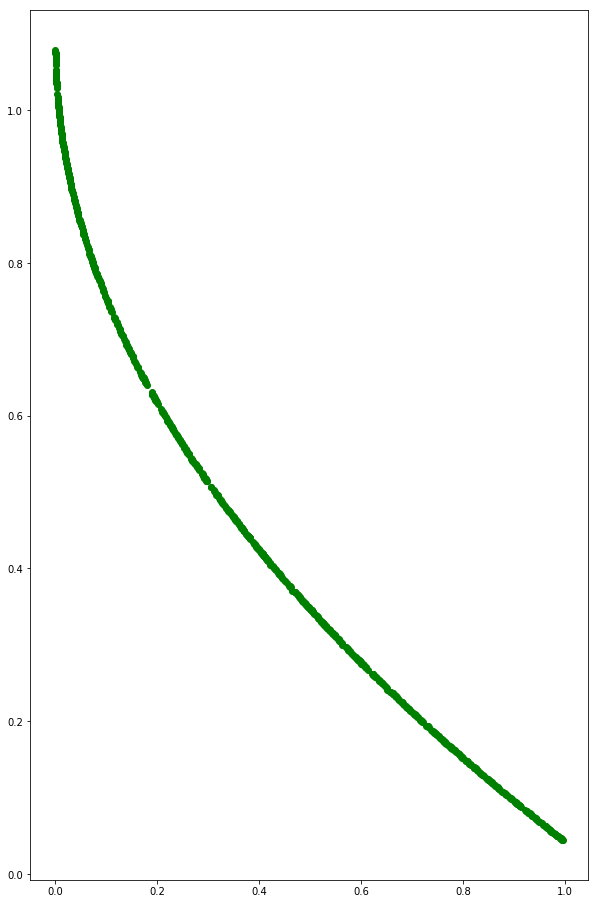

Iteration: 210


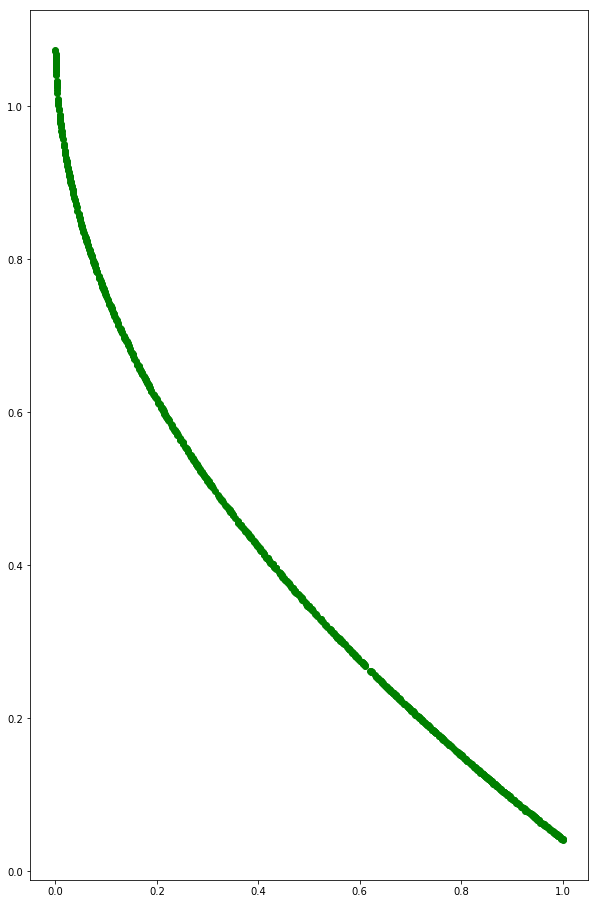

Iteration: 220


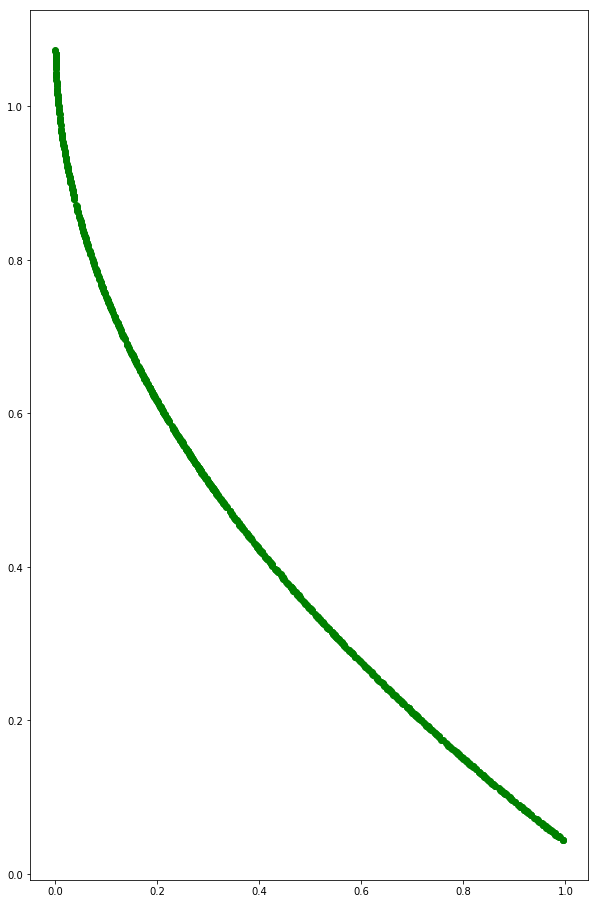

Iteration: 230


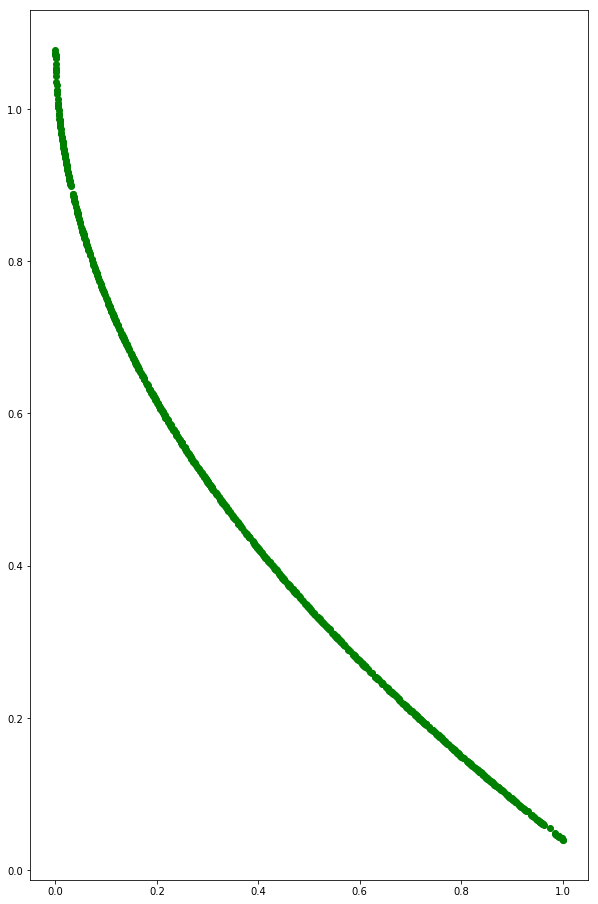

Iteration: 240


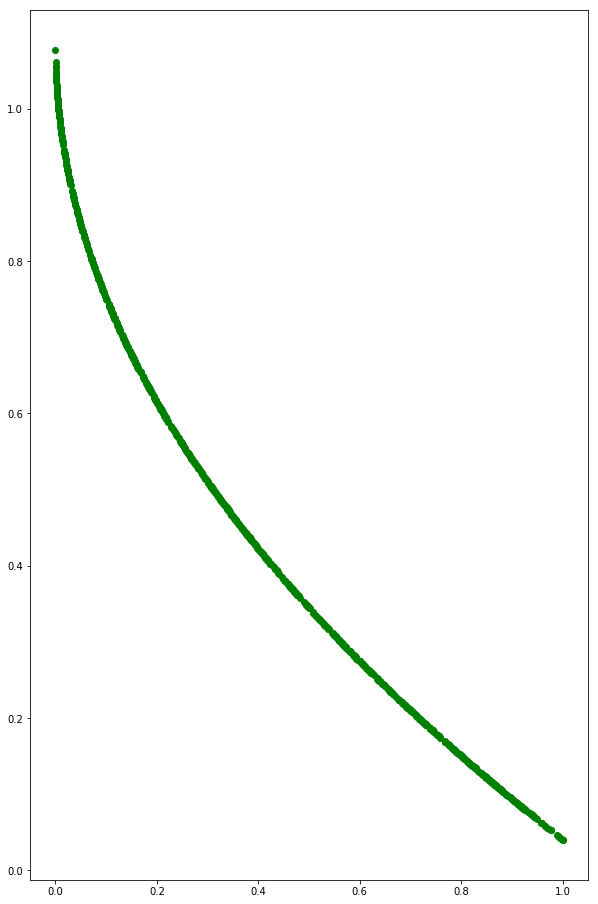

Iteration: 250


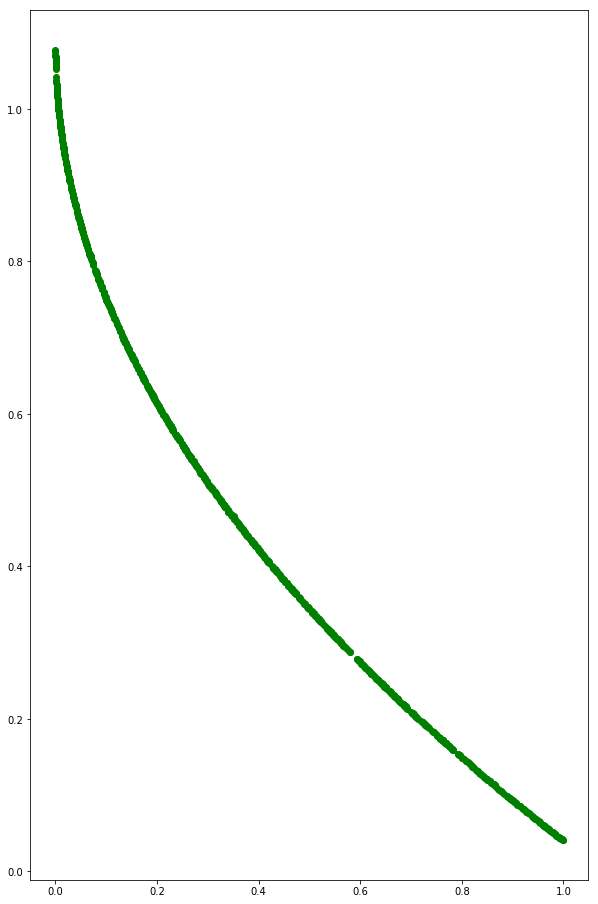

Iteration: 260


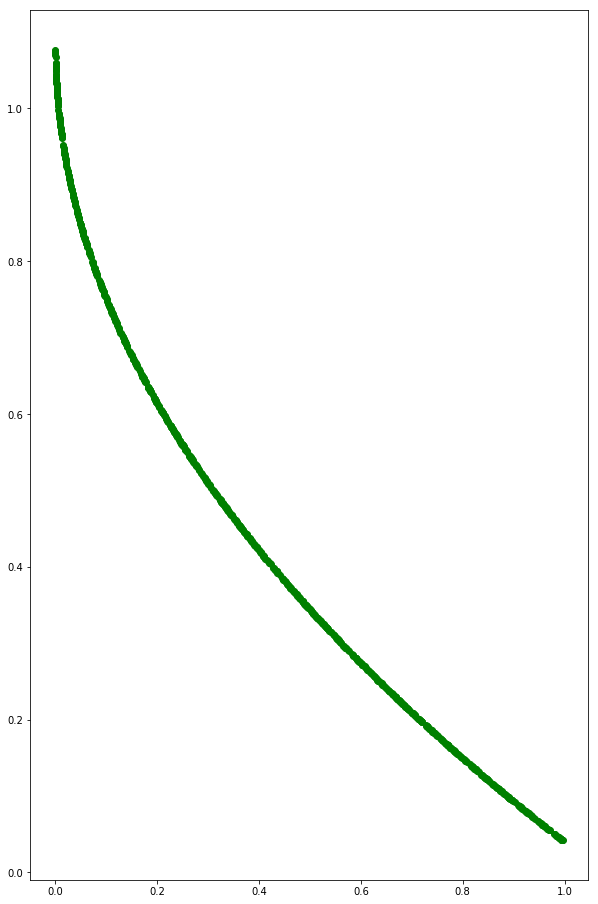

Iteration: 270


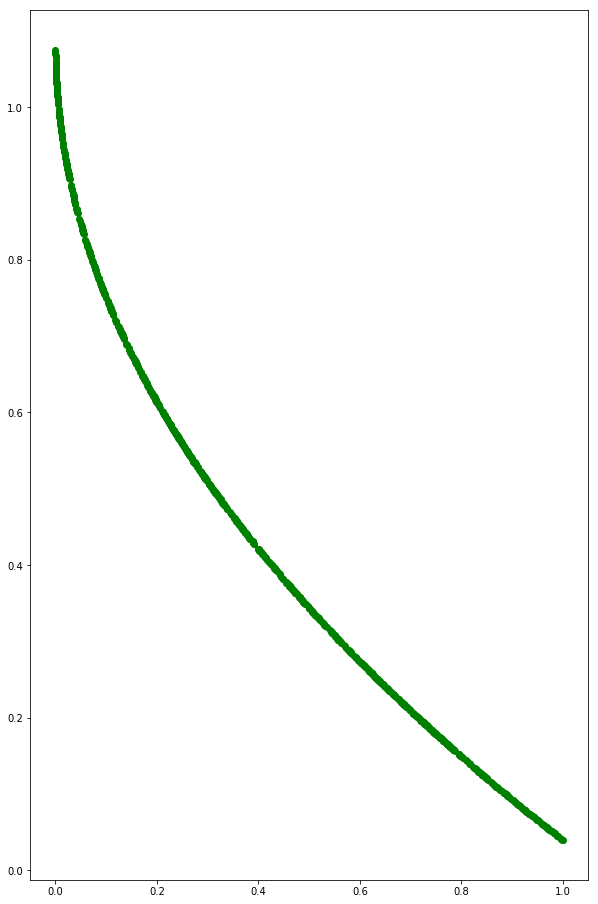

Iteration: 280


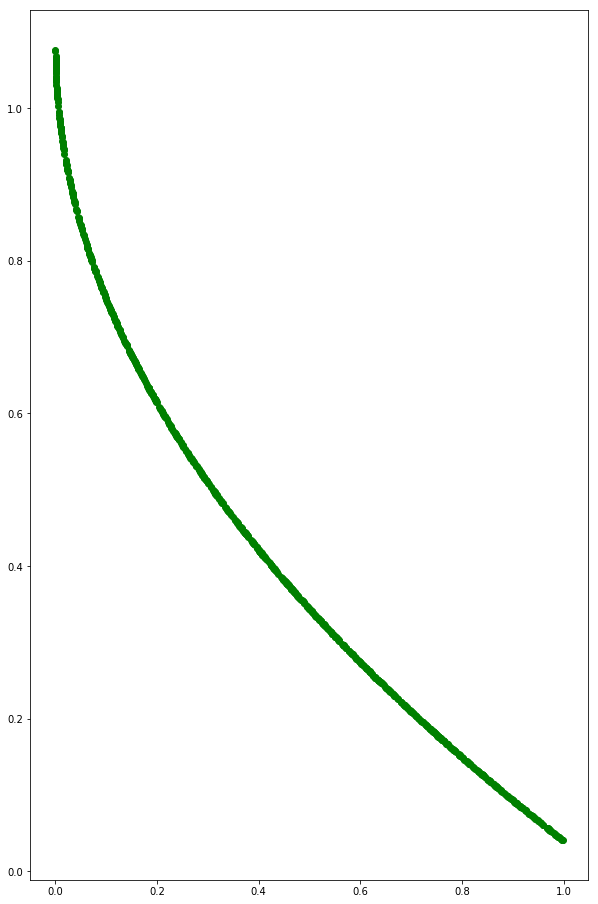

Iteration: 290


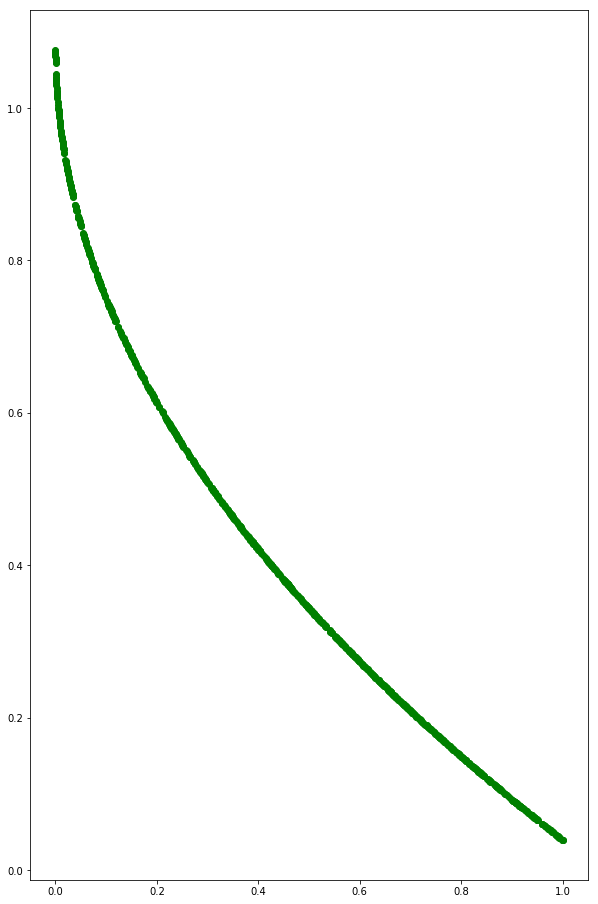

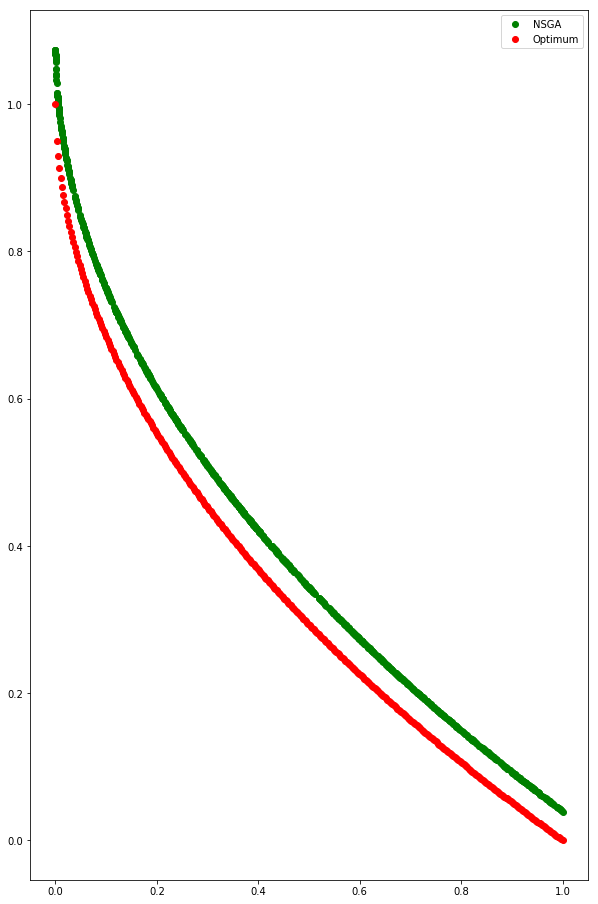

In [268]:
###########
#ZDT1
###########

result = NSGA([ZDT1f1, ZDT1f2], chromosome_length=30, population_size=1000, number_of_iterations=300, number_of_offspring=1000,
       number_of_parents=1, sigma=0.25, tau=0.5, tau_0=0.5, log_frequency=10, min_domain=0.0, max_domain=1.0, mutation_type='no_correl',
      log_function=None)

#print(result)

plt.figure(figsize=(10,16))

optimal_x = np.zeros((400, 30))
optimal_x[:, 0] = np.linspace(0.0, 1.0, 400)
optimal_y = np.array([ZDT1f1(optimal_x), ZDT1f2(optimal_x)])

plt.plot(result[1][0,:], result[1][1,:], 'go', label='NSGA')
plt.plot(optimal_y[0, :], optimal_y[1,:], 'ro', label='Optimum')

plt.legend()

plt.show()

Iteration: 0


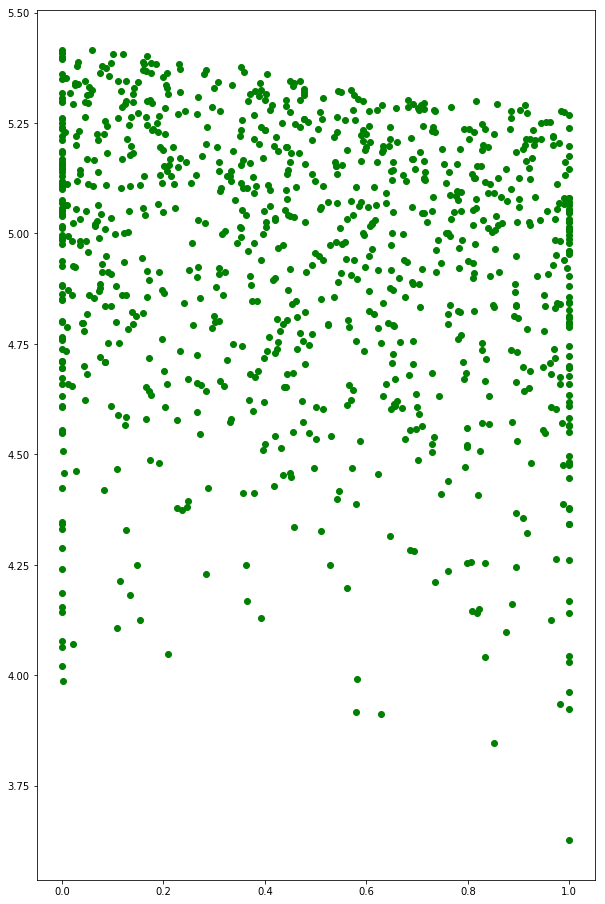

Iteration: 10


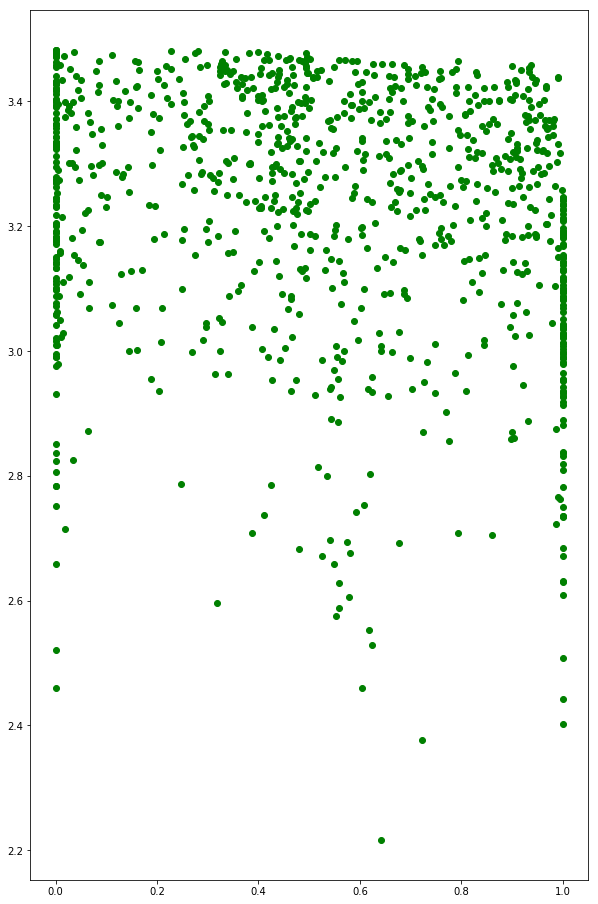

Iteration: 20


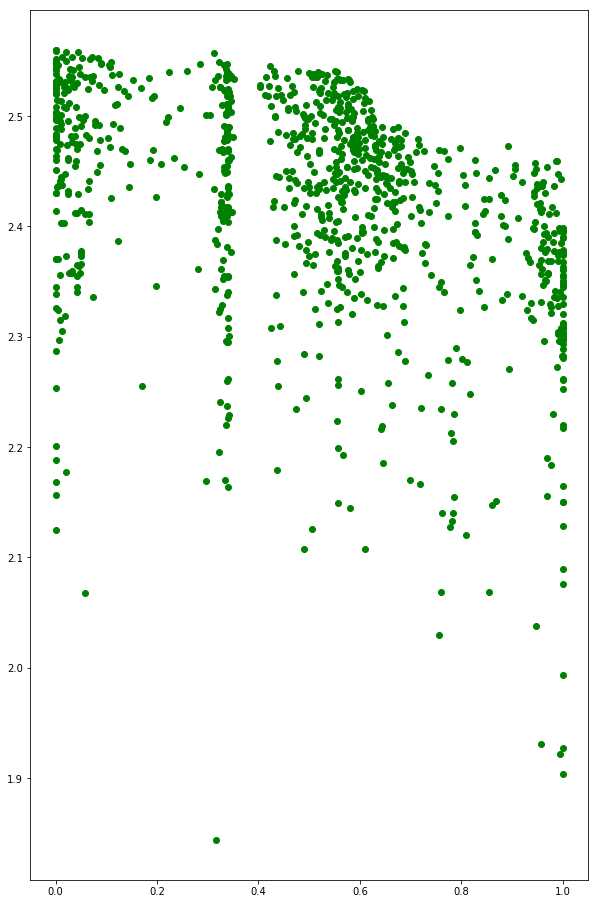

Iteration: 30


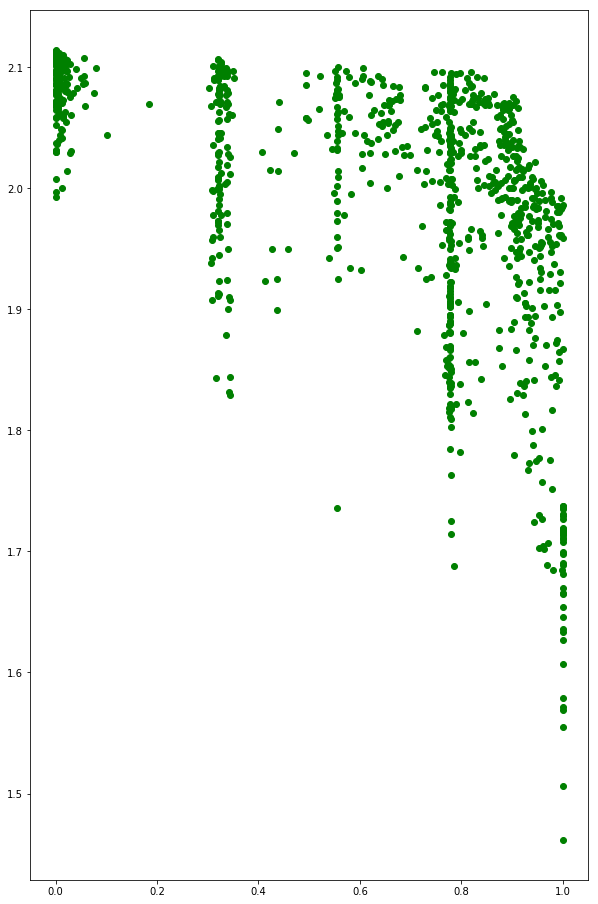

Iteration: 40


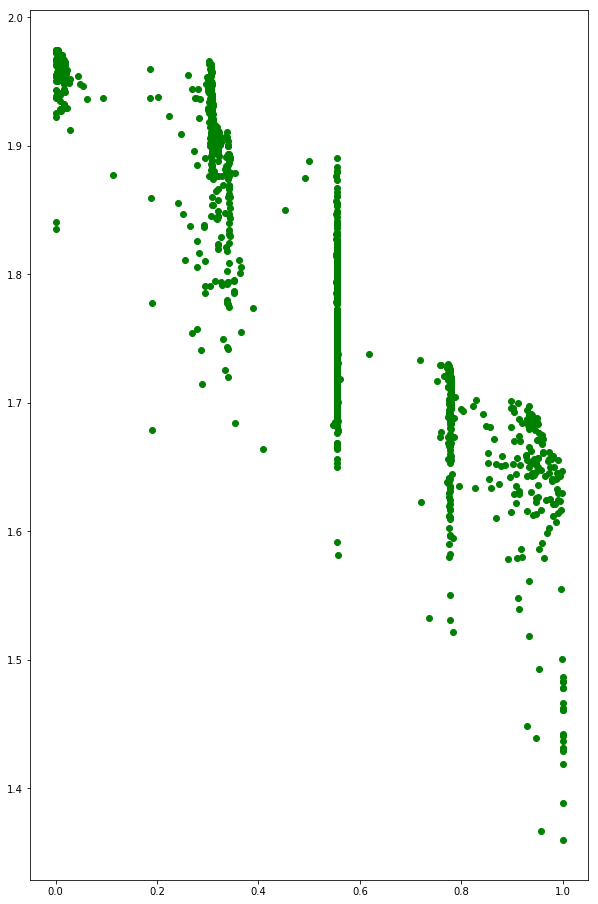

Iteration: 50


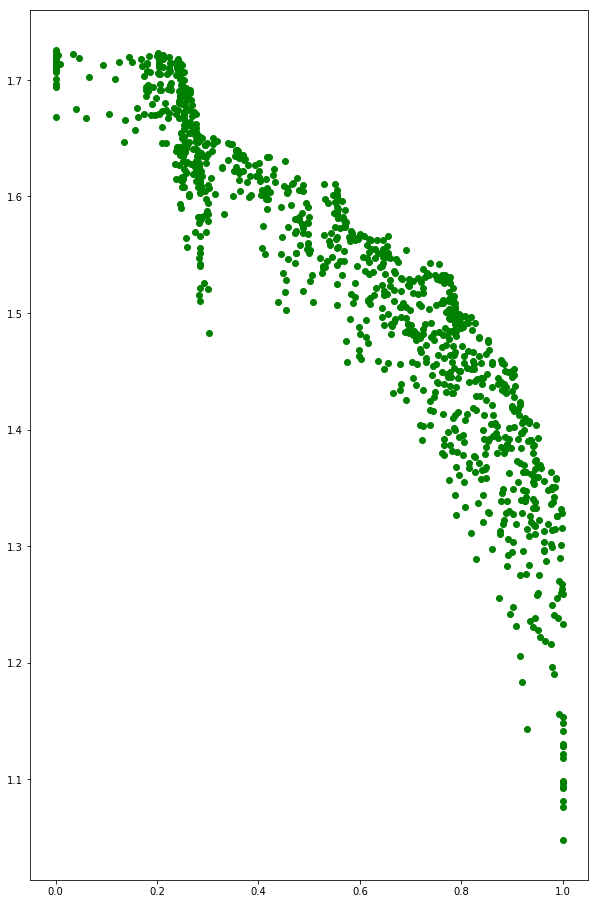

Iteration: 60


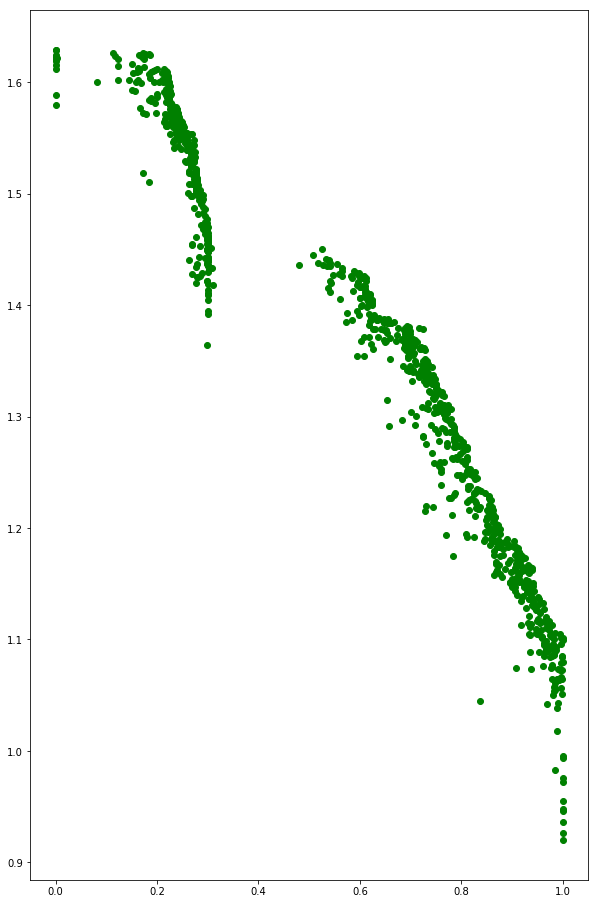

Iteration: 70


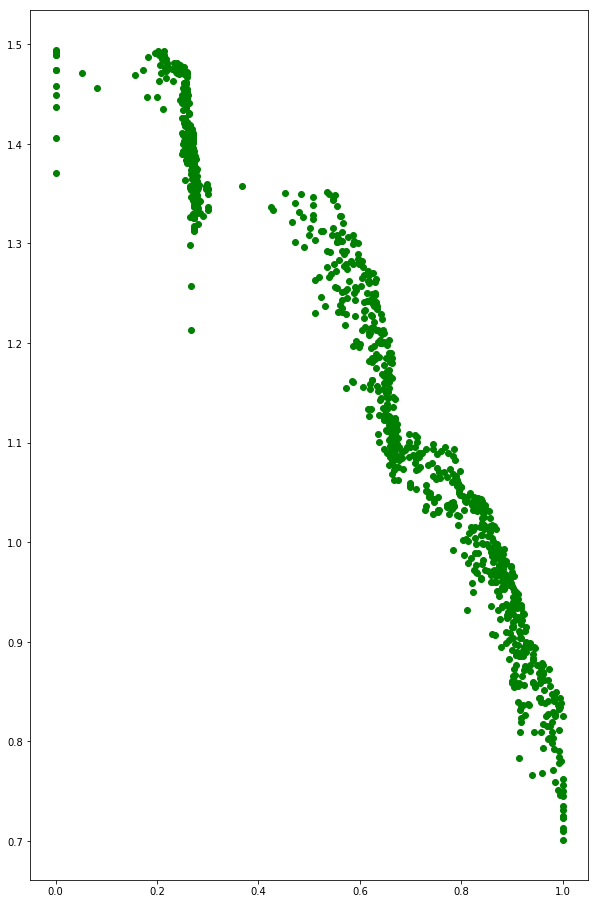

Iteration: 80


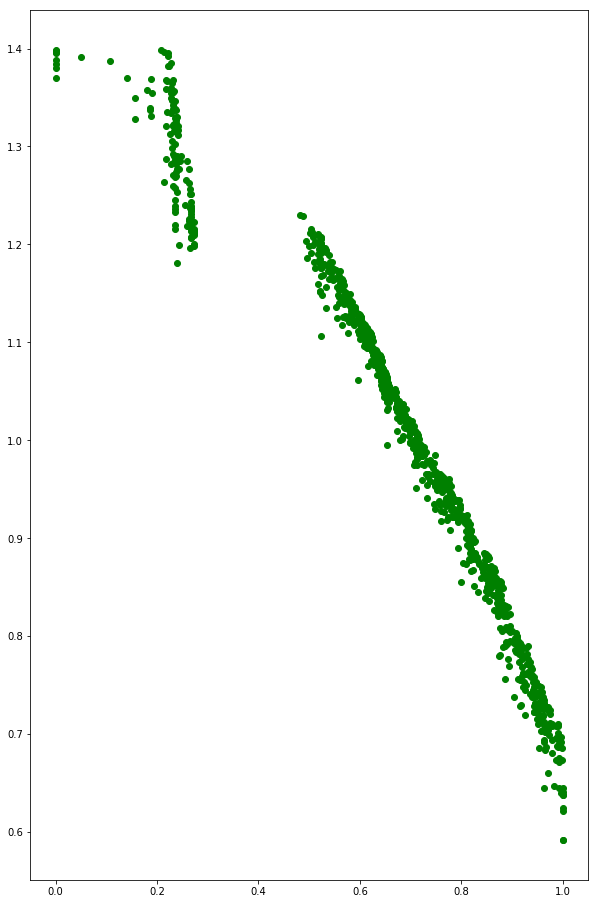

Iteration: 90


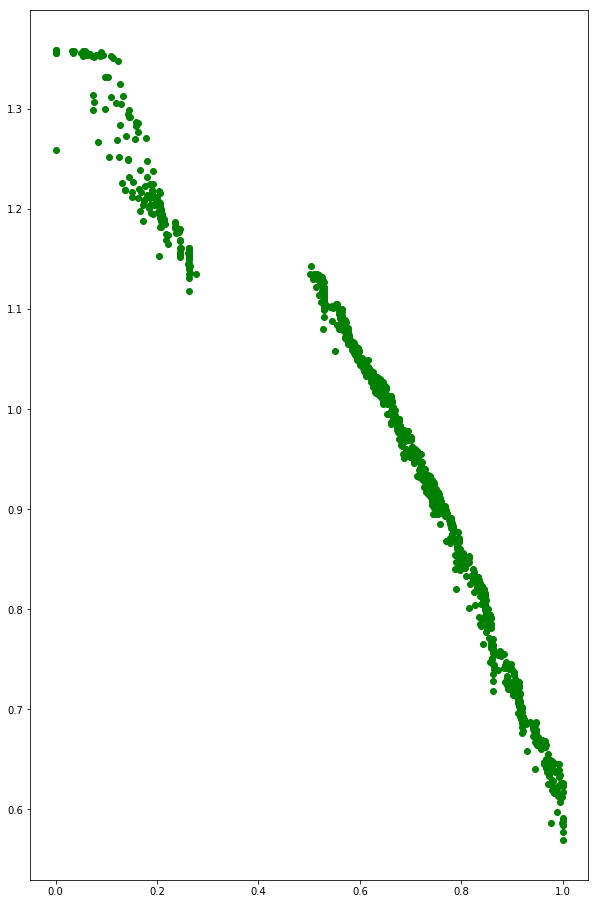

Iteration: 100


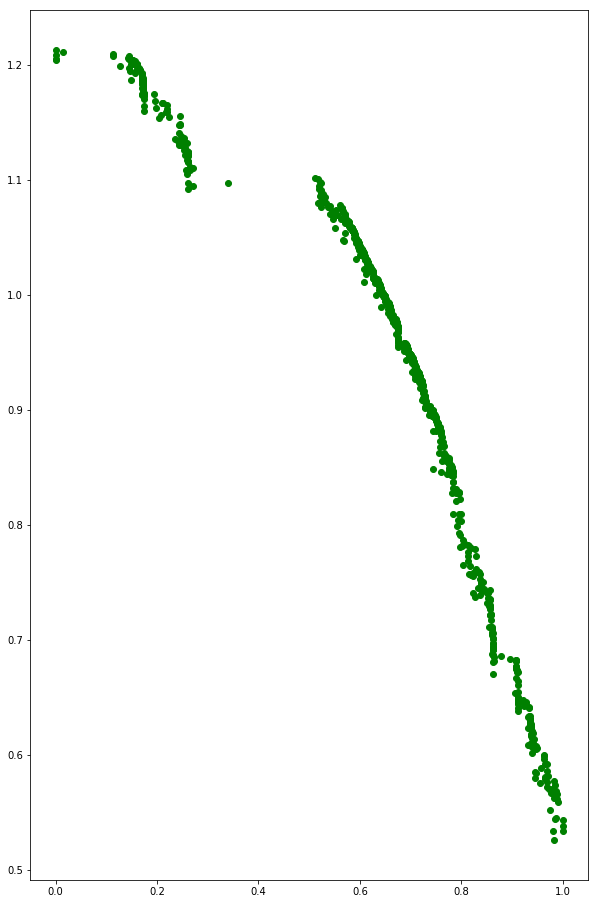

Iteration: 110


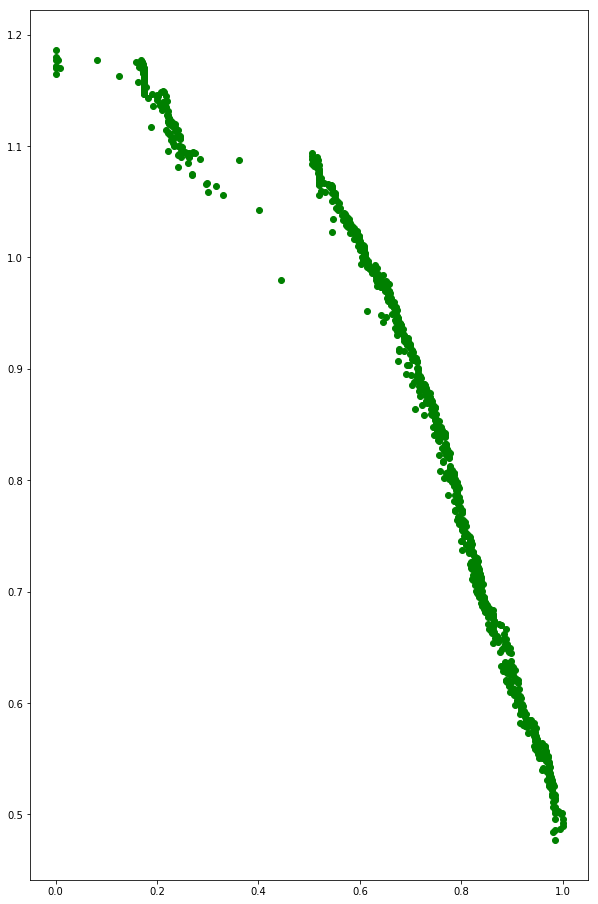

Iteration: 120


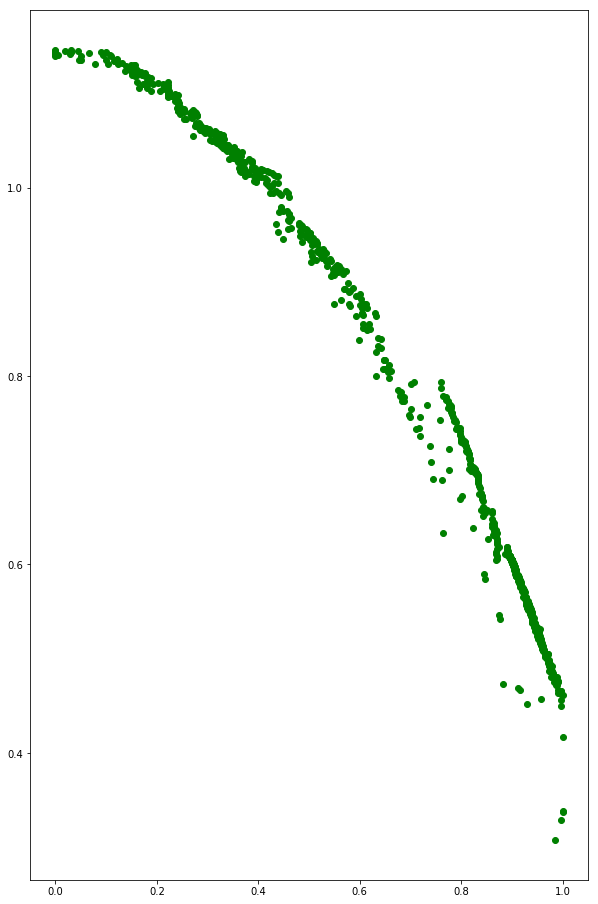

Iteration: 130


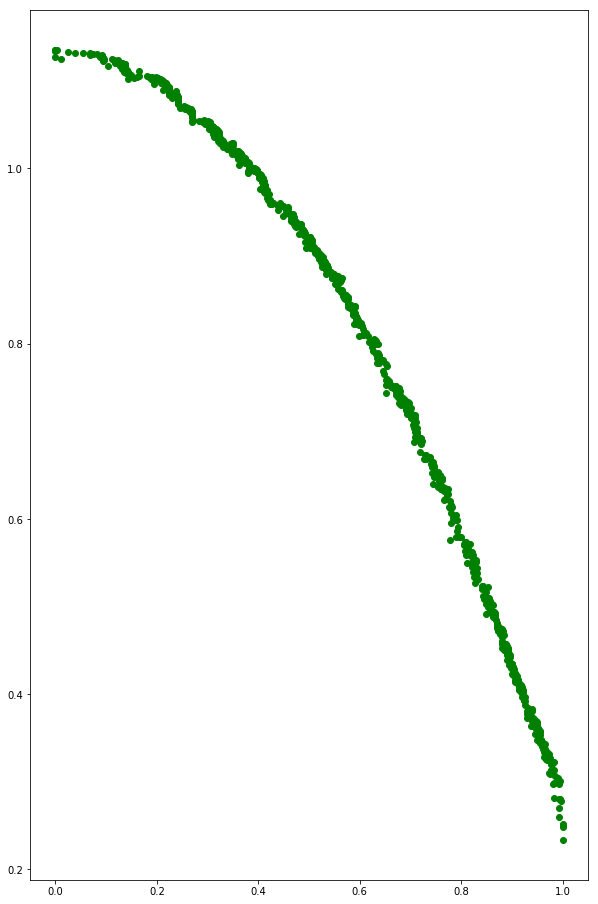

Iteration: 140


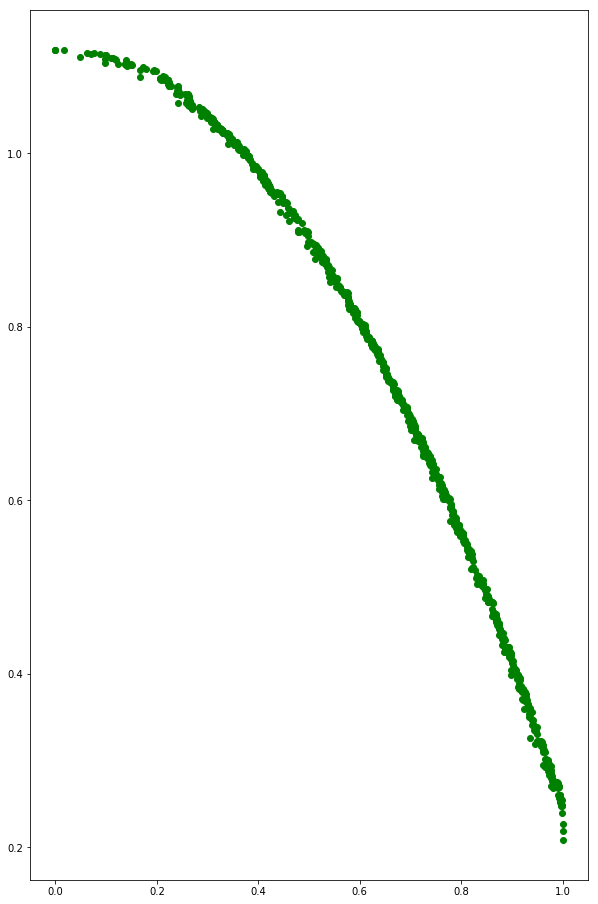

Iteration: 150


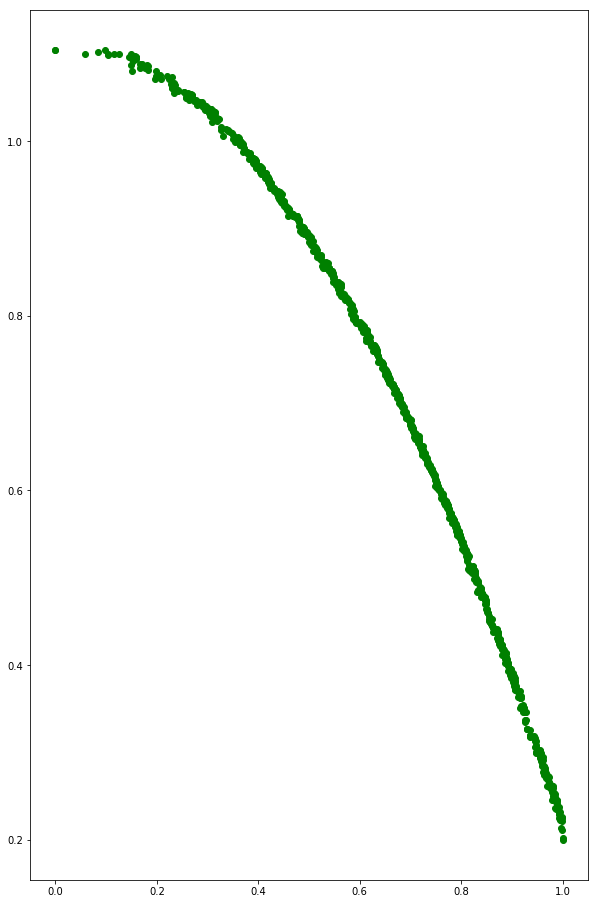

Iteration: 160


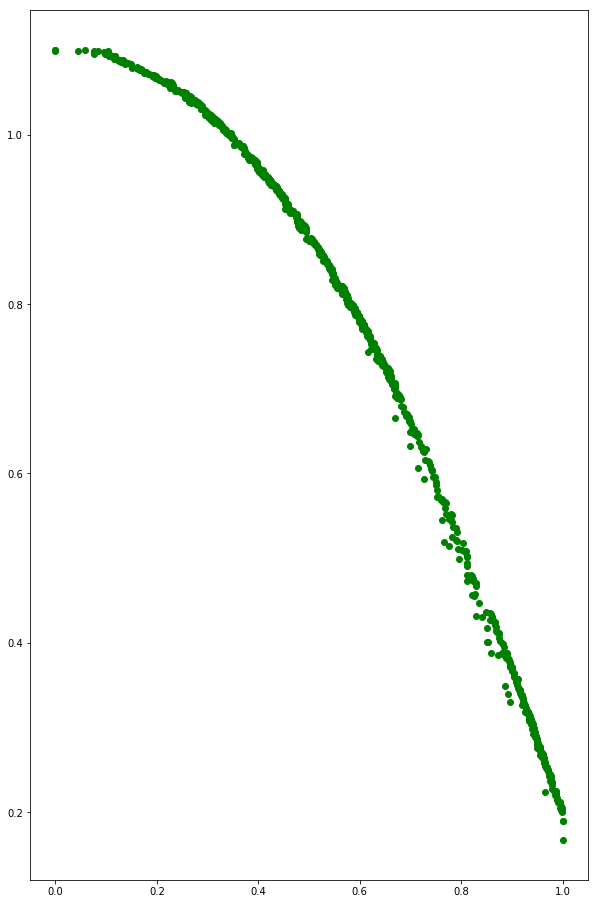

Iteration: 170


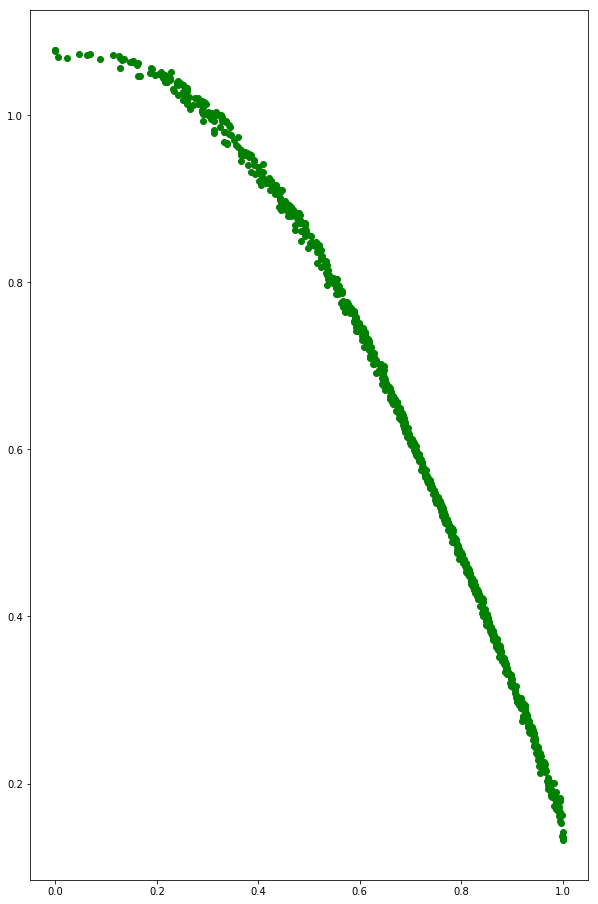

Iteration: 180


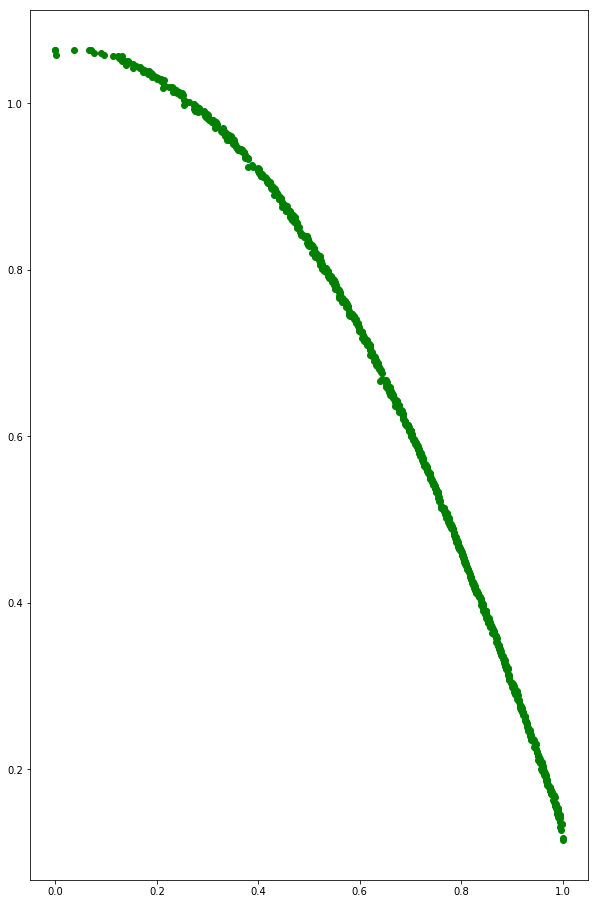

Iteration: 190


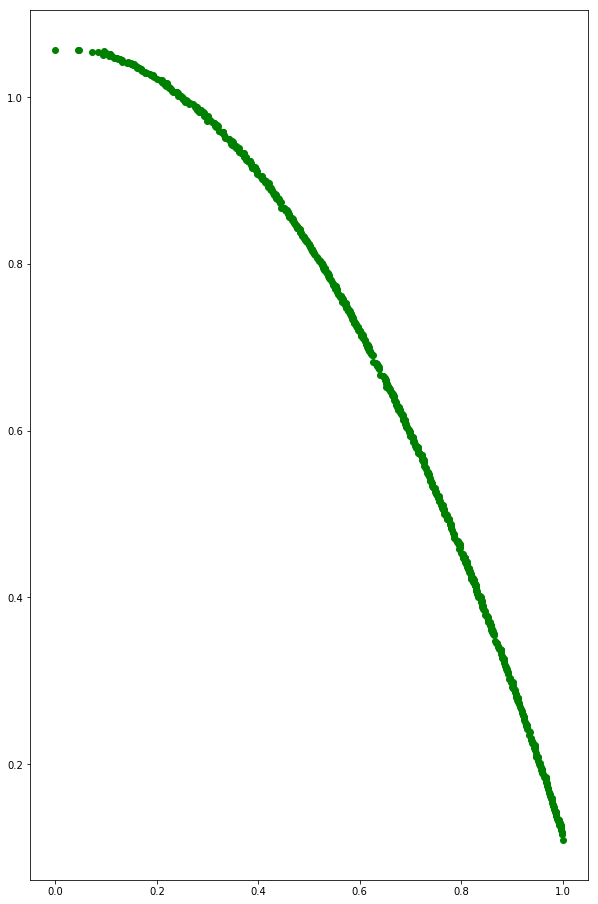

Iteration: 200


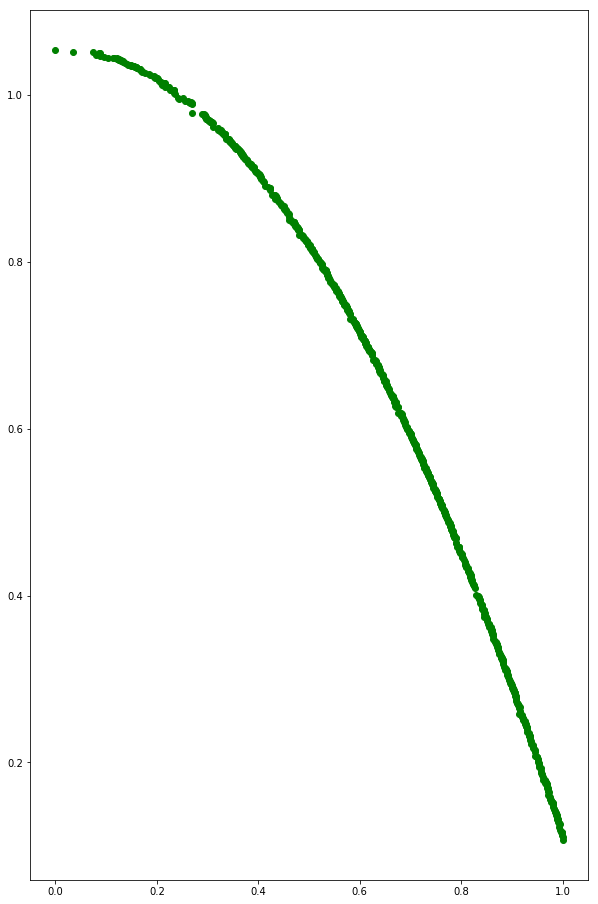

Iteration: 210


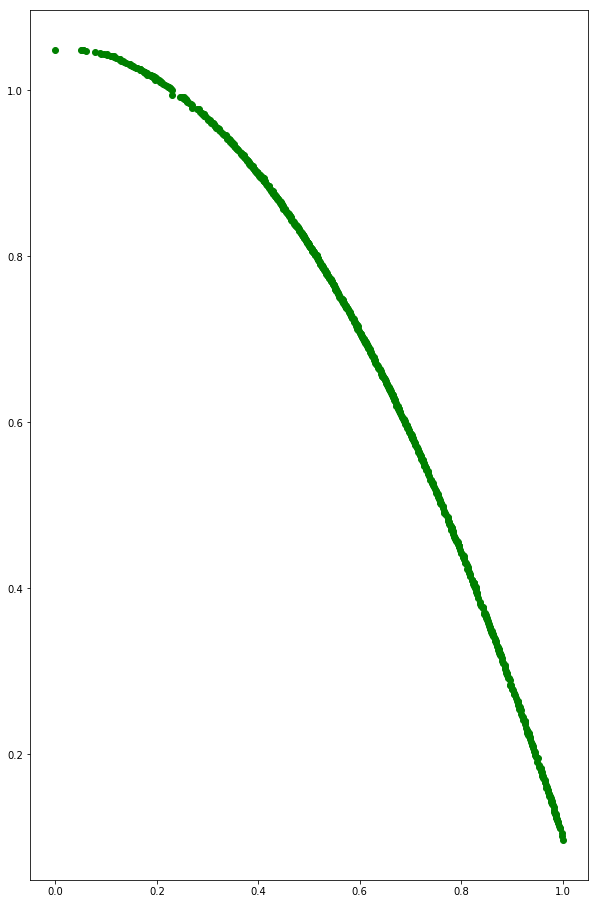

Iteration: 220


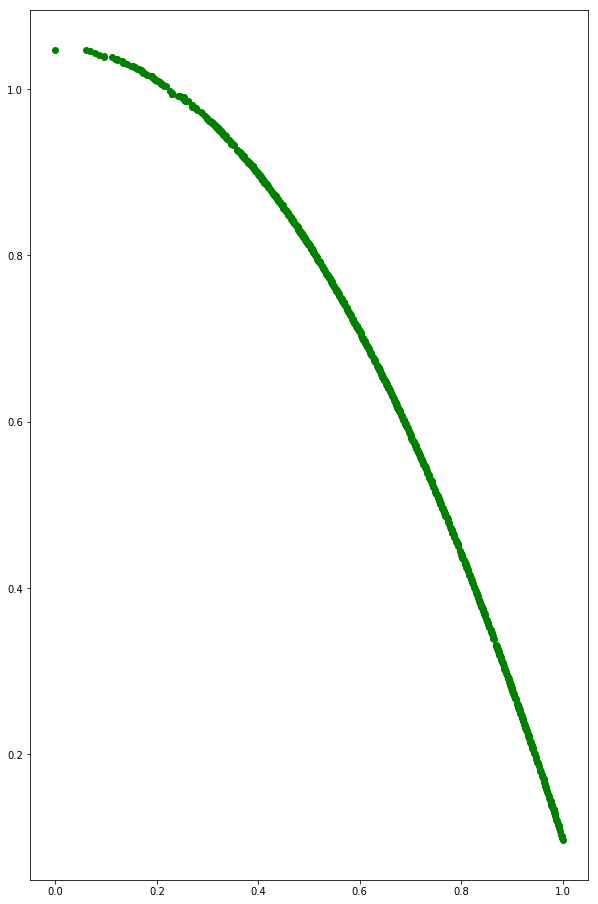

Iteration: 230


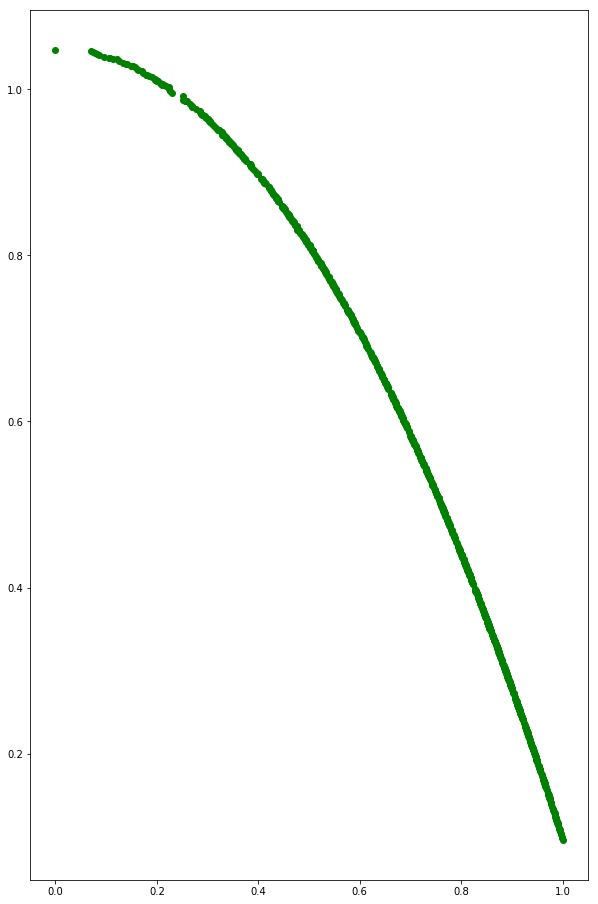

Iteration: 240


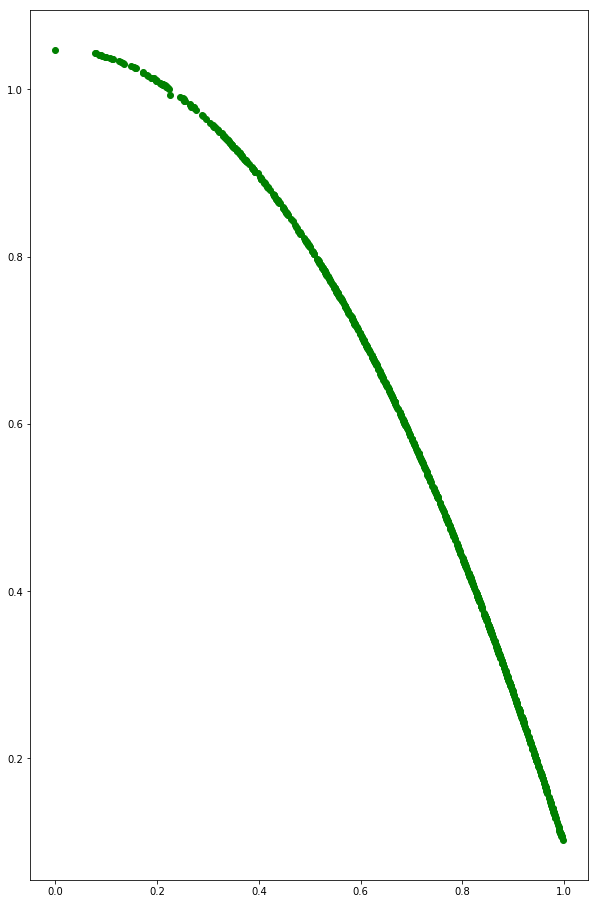

Iteration: 250


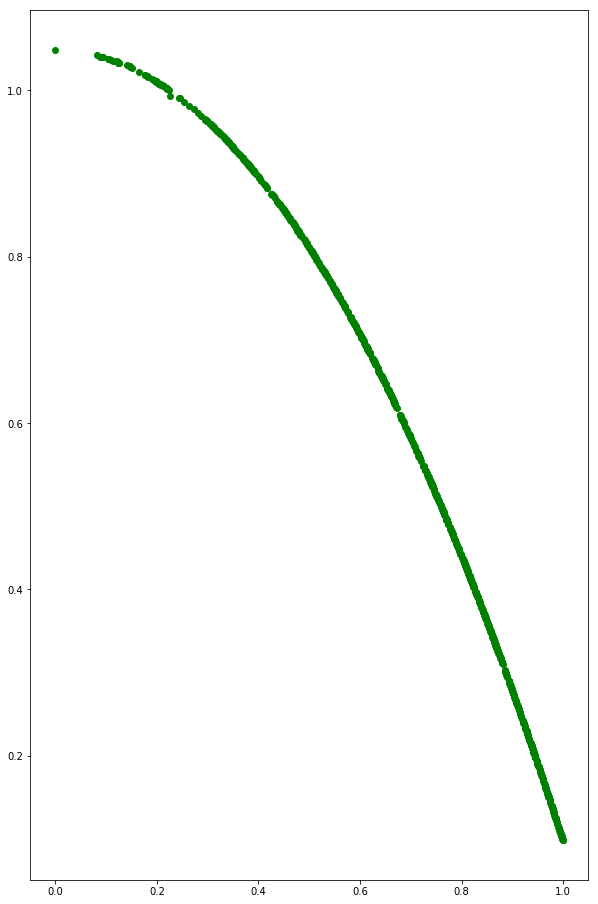

Iteration: 260


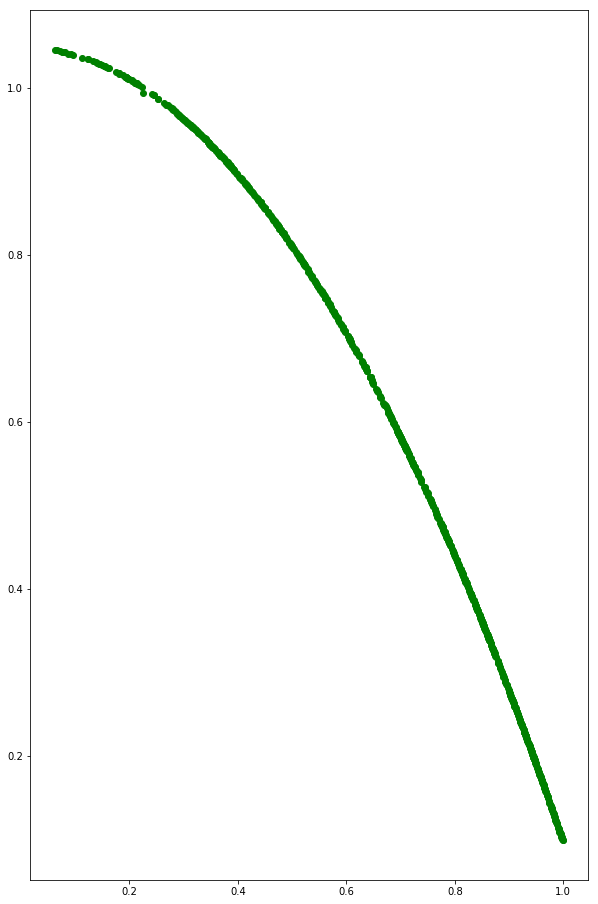

Iteration: 270


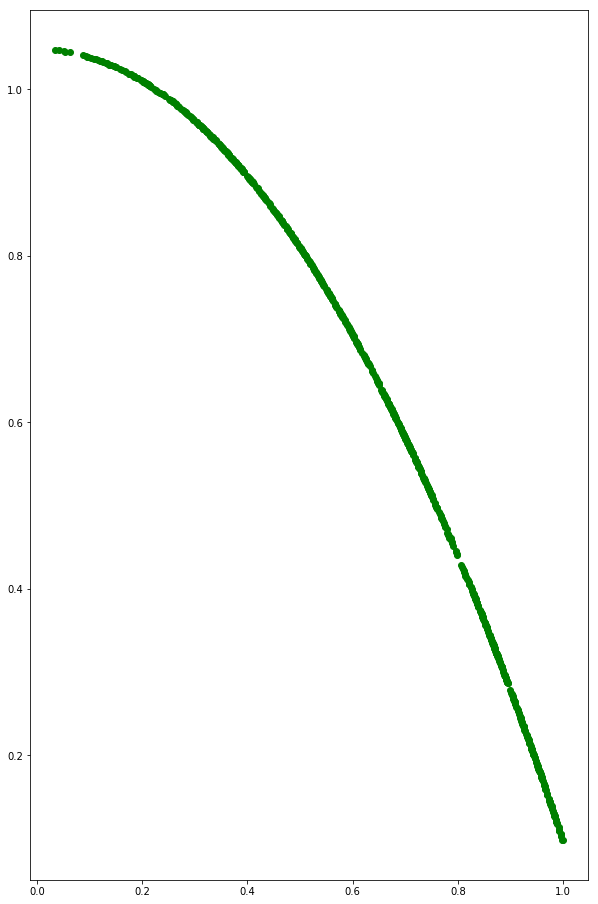

Iteration: 280


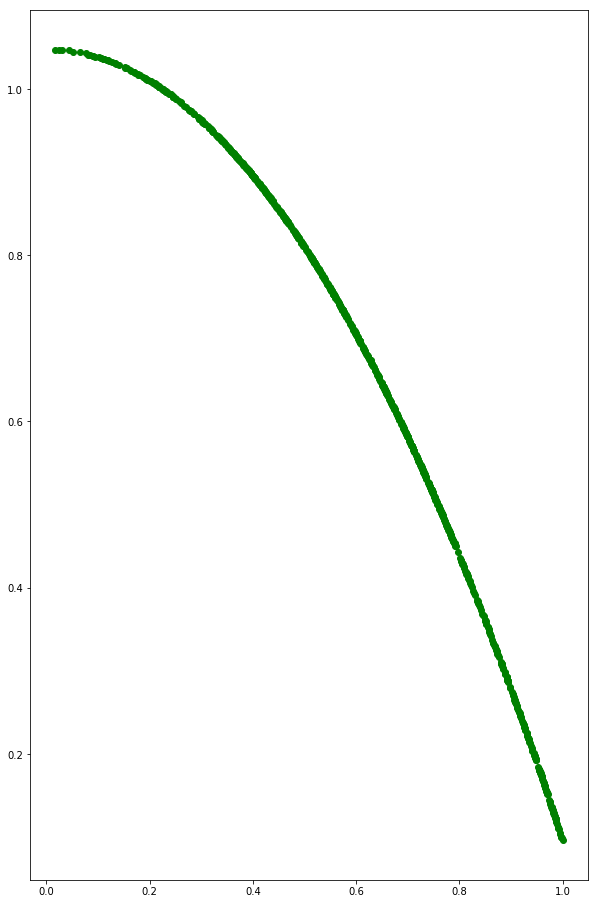

Iteration: 290


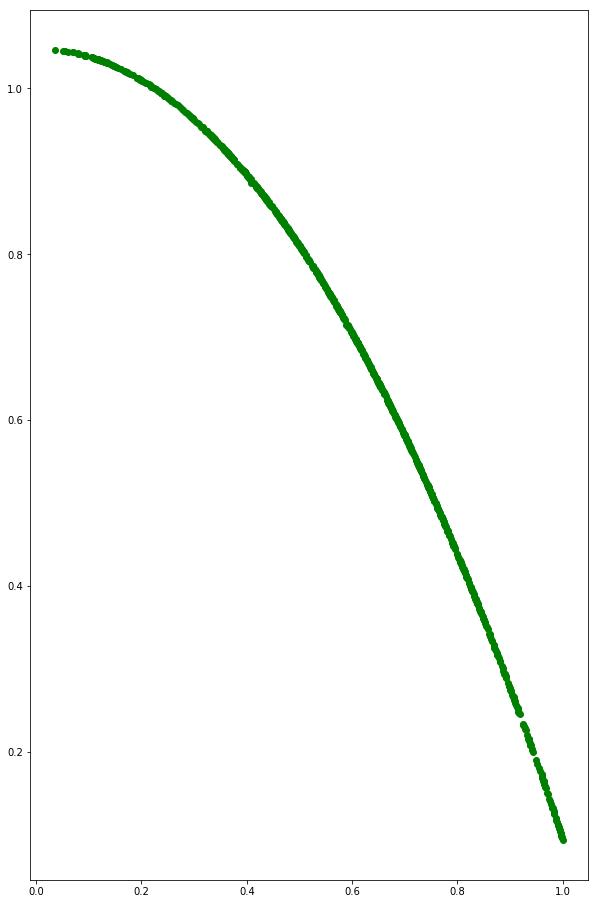

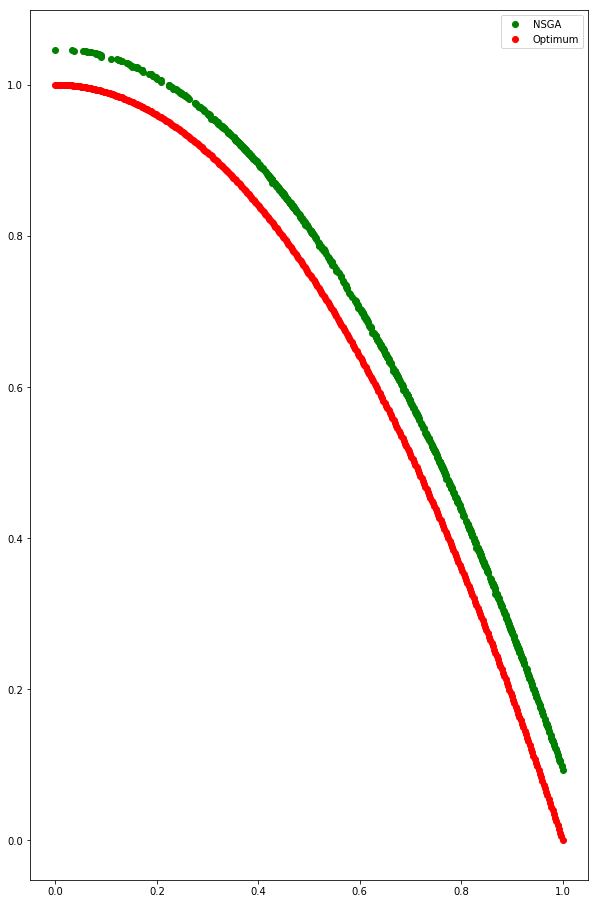

In [269]:
###########
#ZDT2
###########
result = NSGA([ZDT2f1, ZDT2f2], chromosome_length=30, population_size=1000, number_of_iterations=300, number_of_offspring=1000,
       number_of_parents=1, sigma=0.25, tau=0.5, tau_0=0.5, log_frequency=10, min_domain=0.0, max_domain=1.0, mutation_type='no_correl',
      log_function=None)

#print(result)

plt.figure(figsize=(10,16))

optimal_x = np.zeros((400, 30))
optimal_x[:, 0] = np.linspace(0.0, 1.0, 400)
optimal_y = np.array([ZDT2f1(optimal_x), ZDT2f2(optimal_x)])

plt.plot(result[1][0,:], result[1][1,:], 'go', label='NSGA')
plt.plot(optimal_y[0, :], optimal_y[1,:], 'ro', label='Optimum')

plt.legend()

plt.show()

Iteration: 0


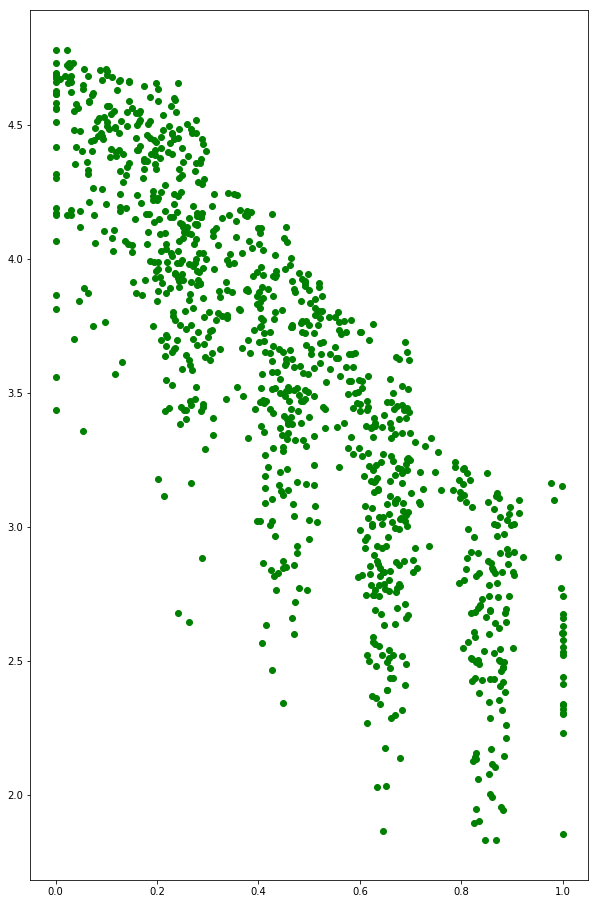

Iteration: 10


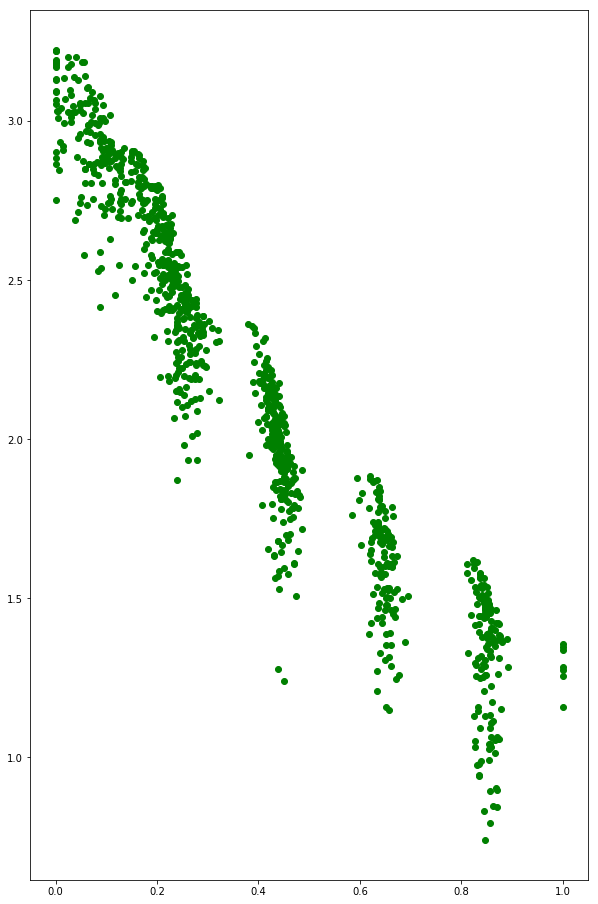

Iteration: 20


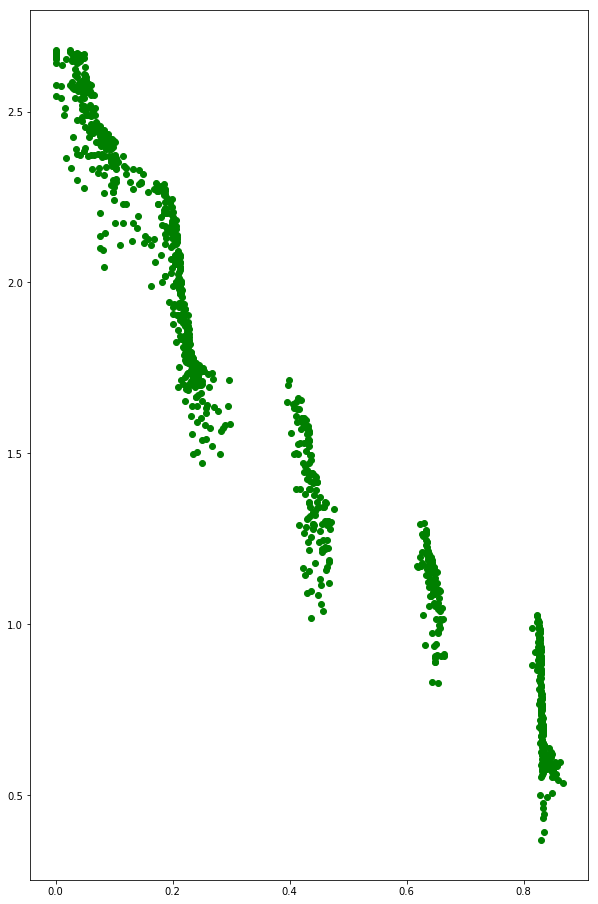

Iteration: 30


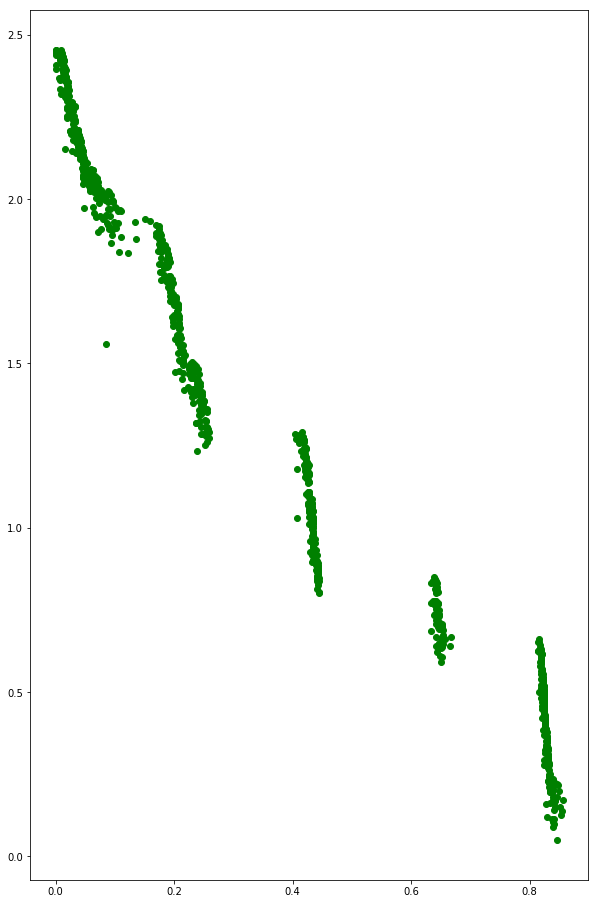

Iteration: 40


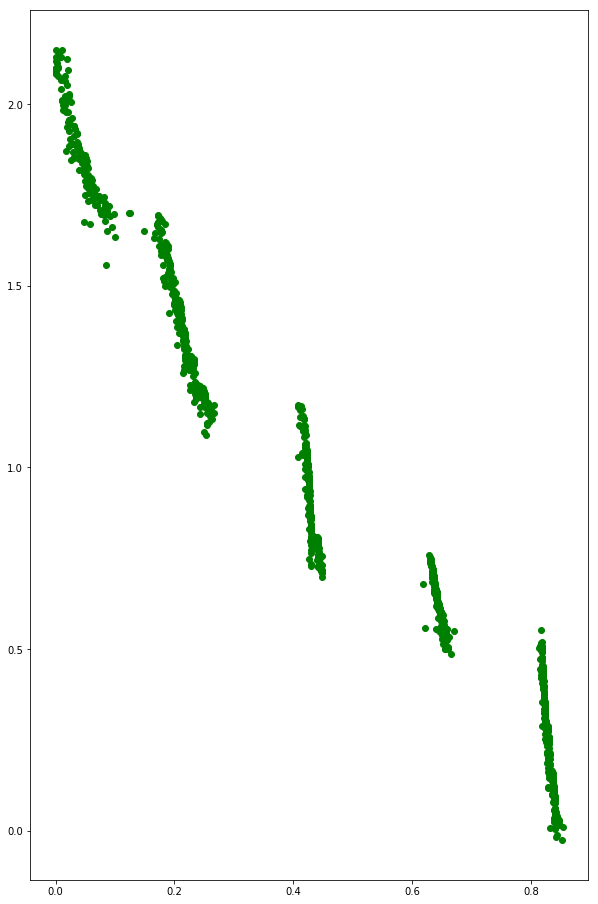

Iteration: 50


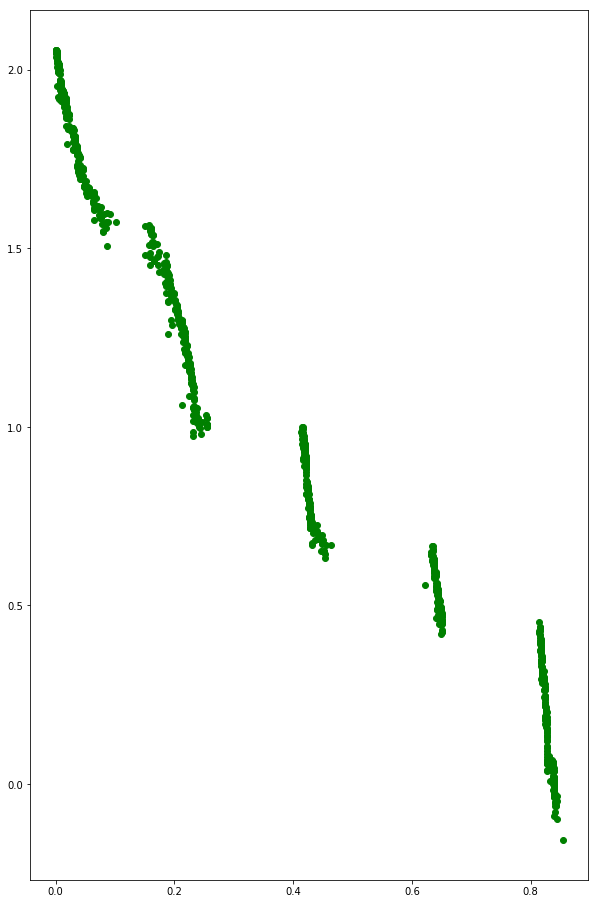

Iteration: 60


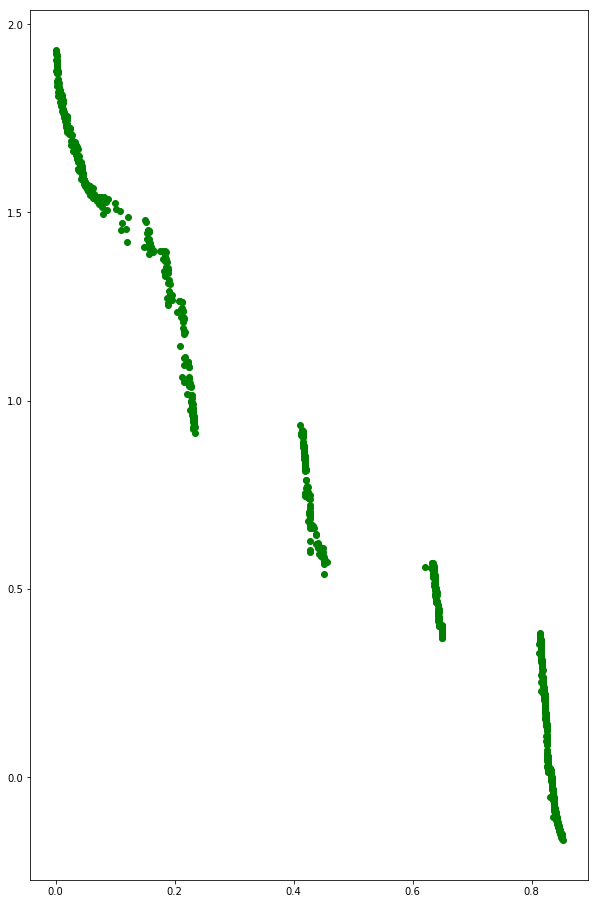

Iteration: 70


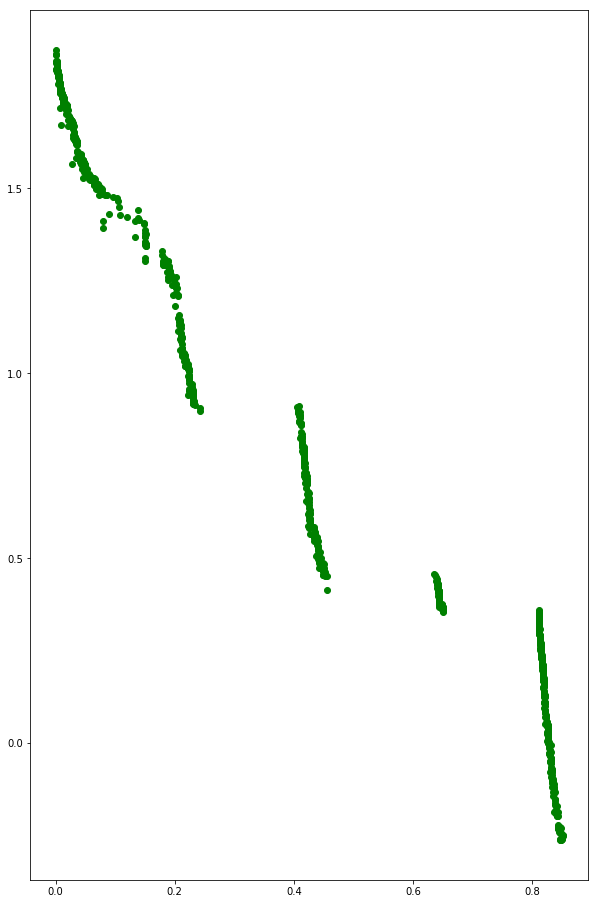

Iteration: 80


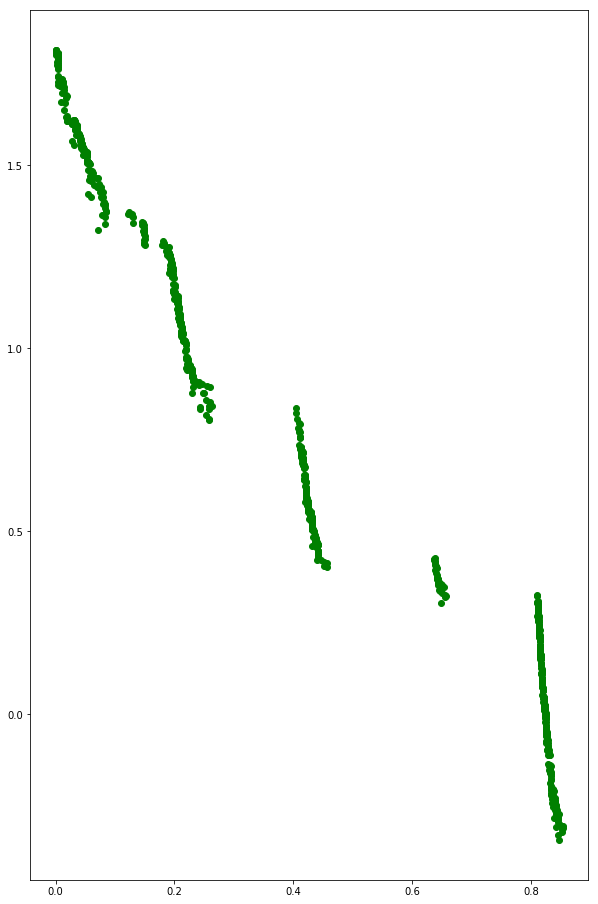

Iteration: 90


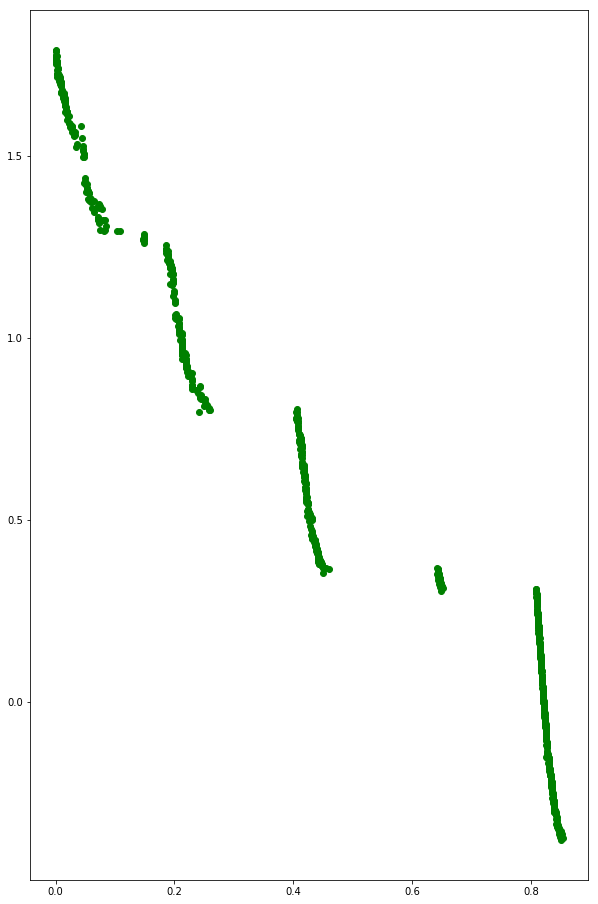

Iteration: 100


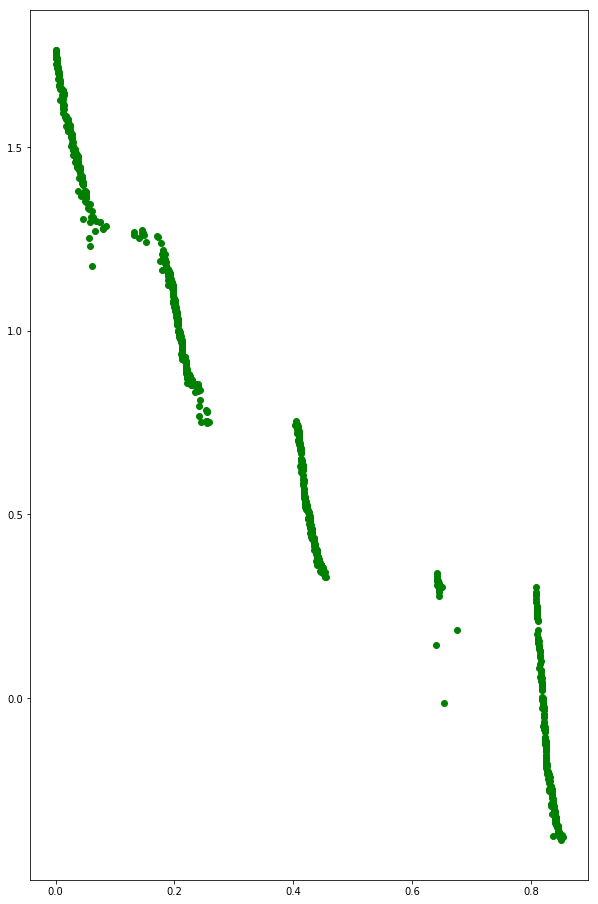

Iteration: 110


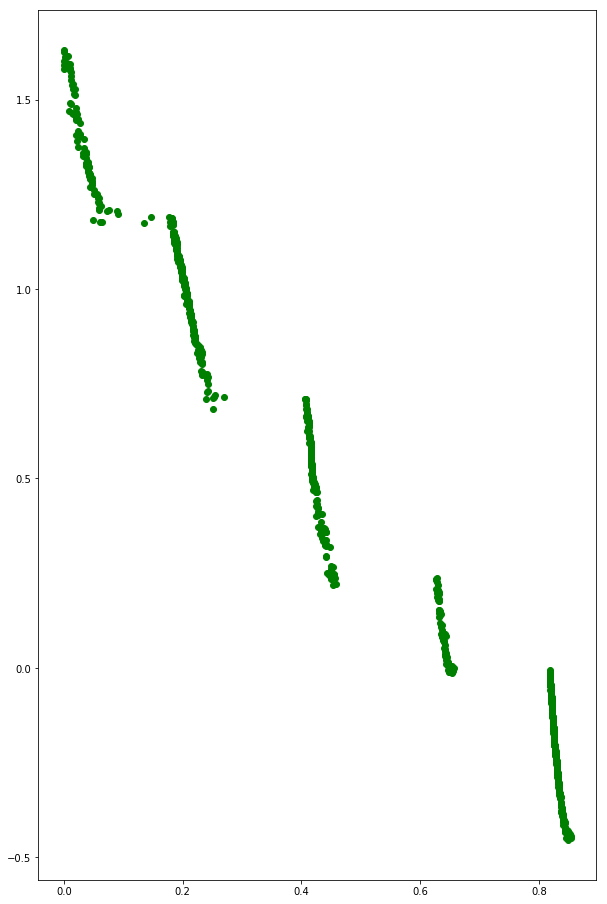

Iteration: 120


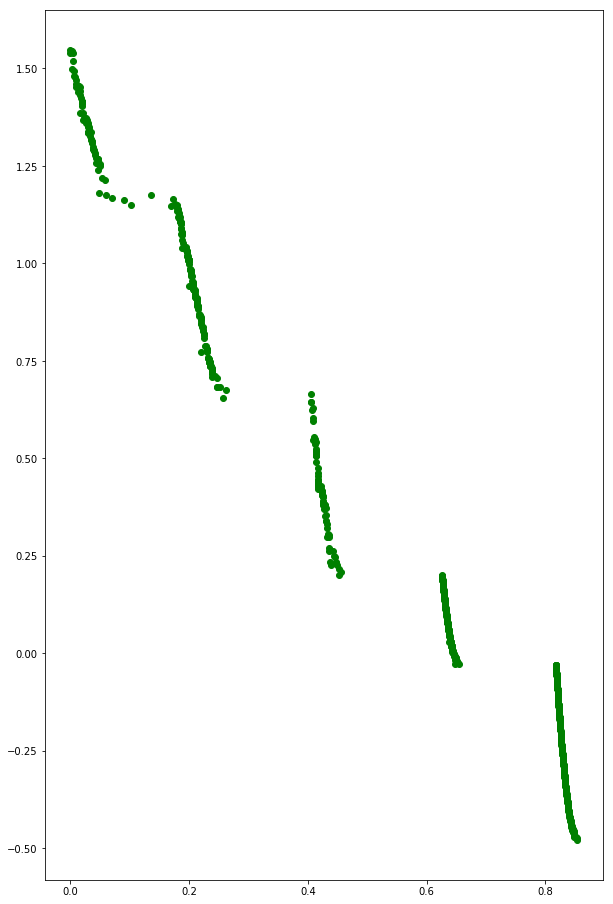

Iteration: 130


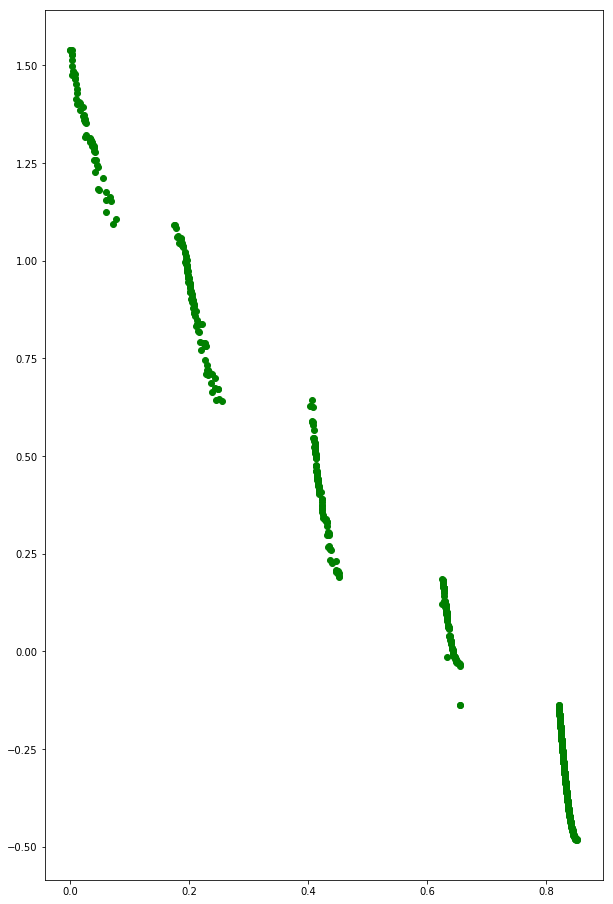

Iteration: 140


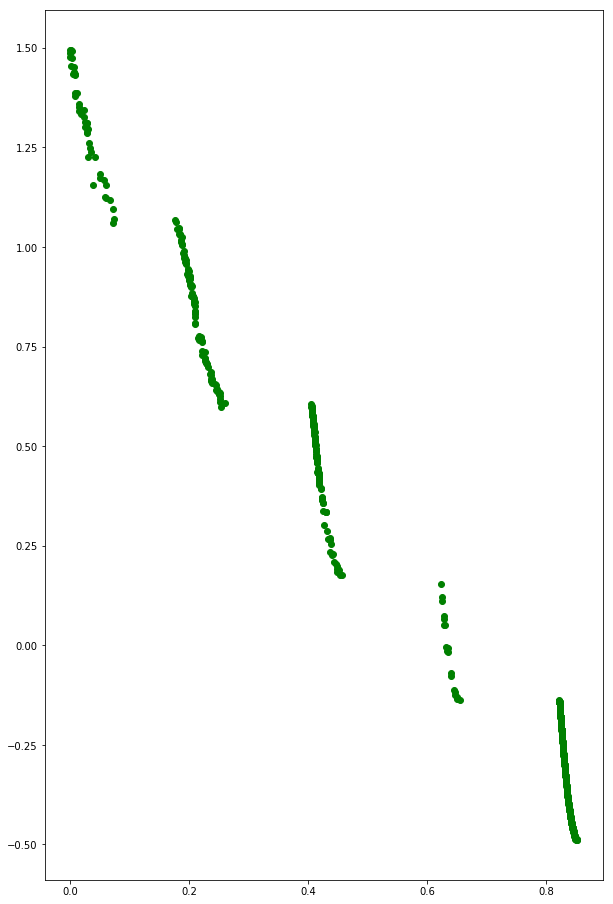

Iteration: 150


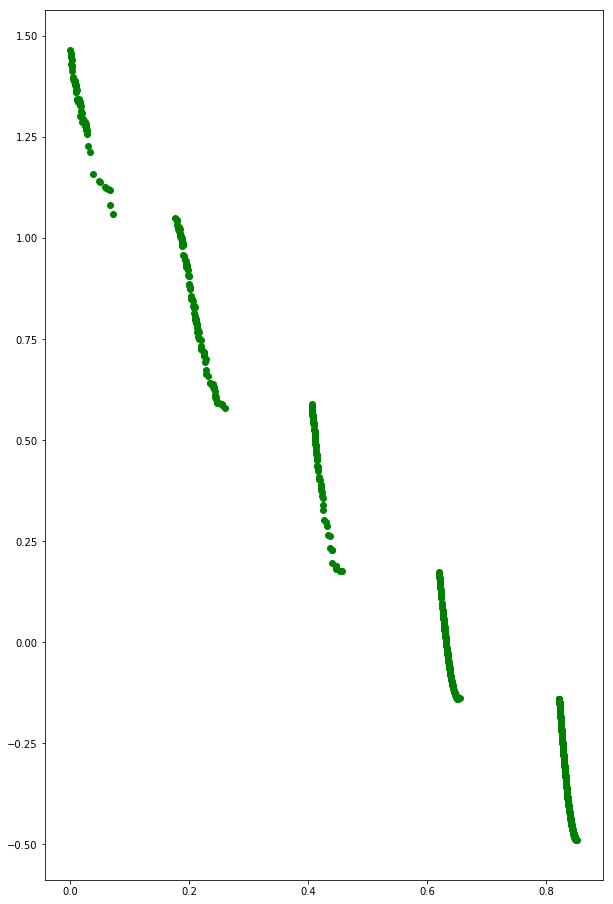

Iteration: 160


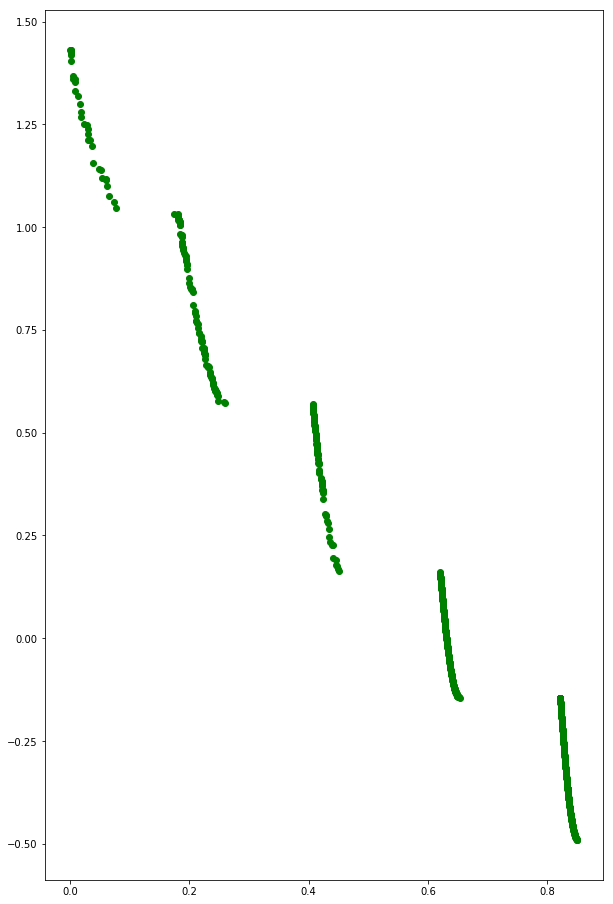

Iteration: 170


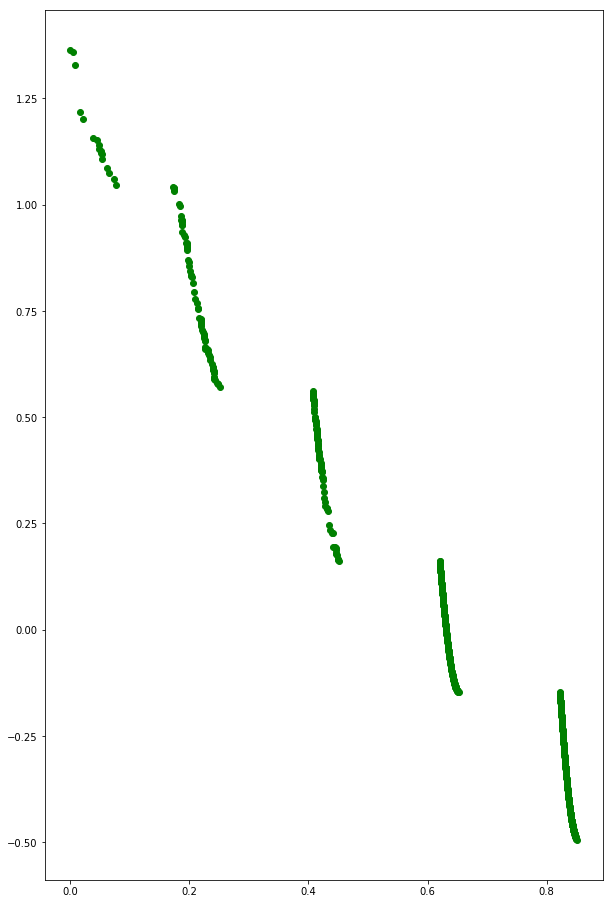

Iteration: 180


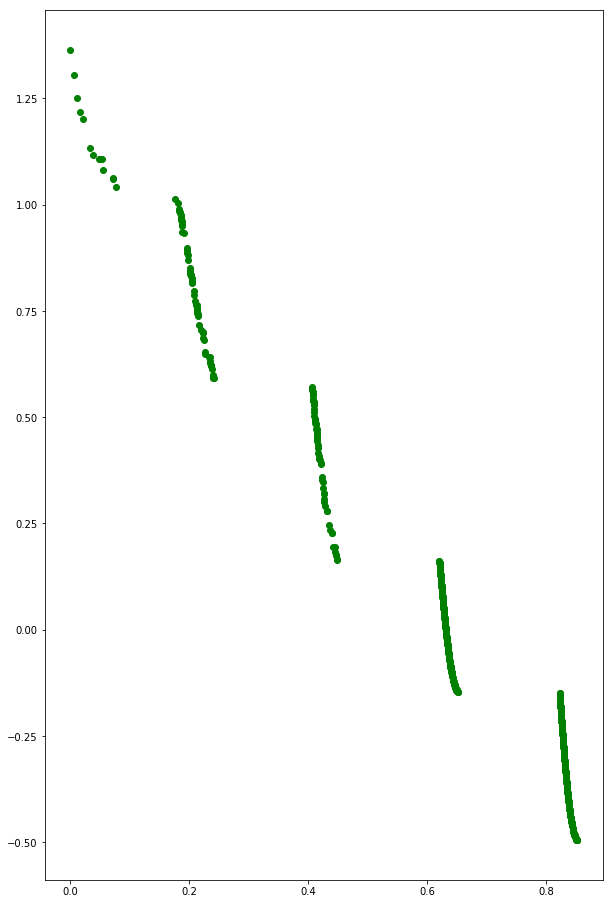

Iteration: 190


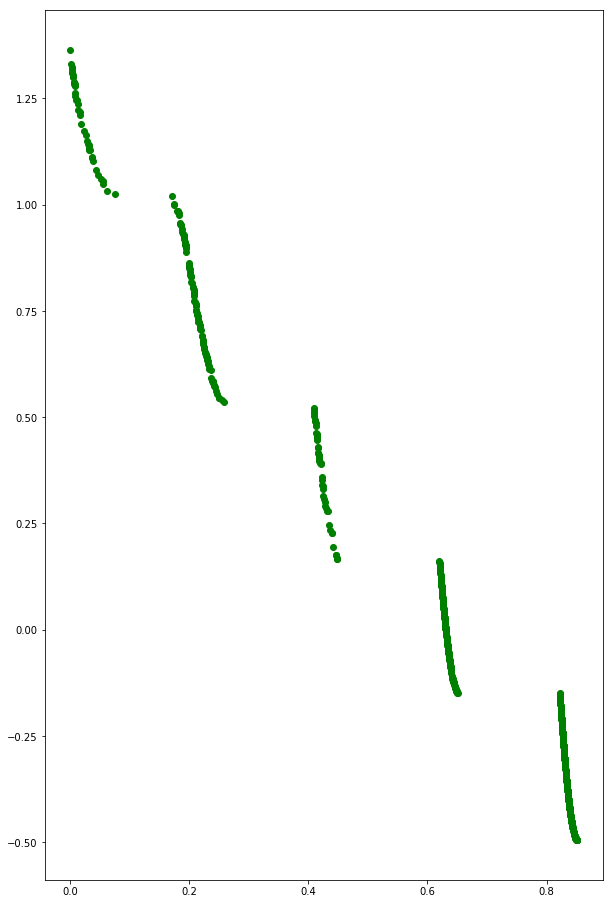

Iteration: 200


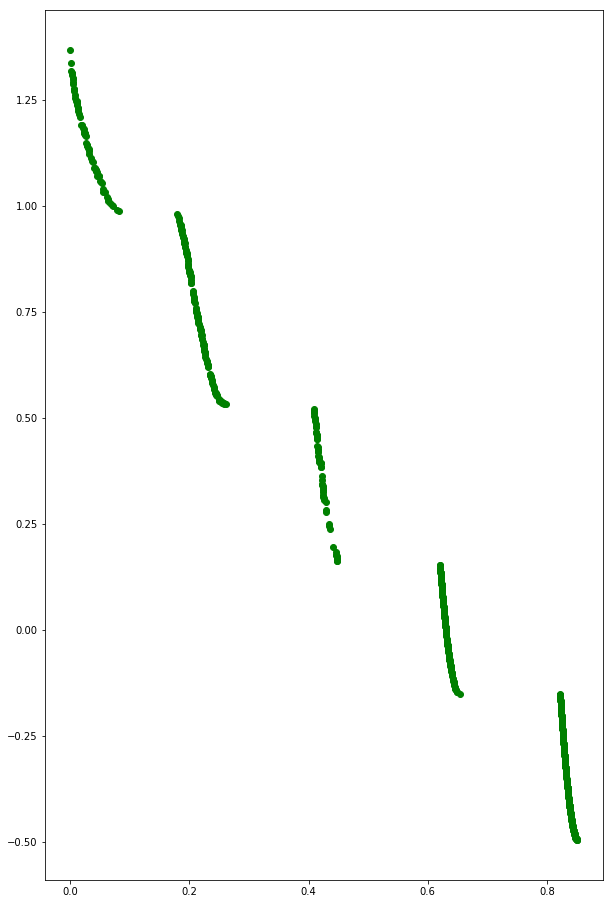

Iteration: 210


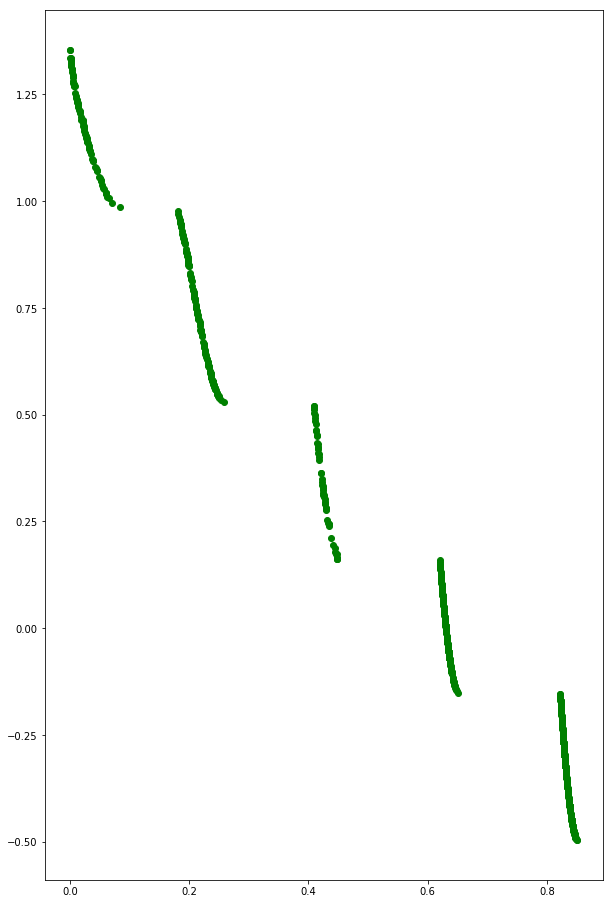

Iteration: 220


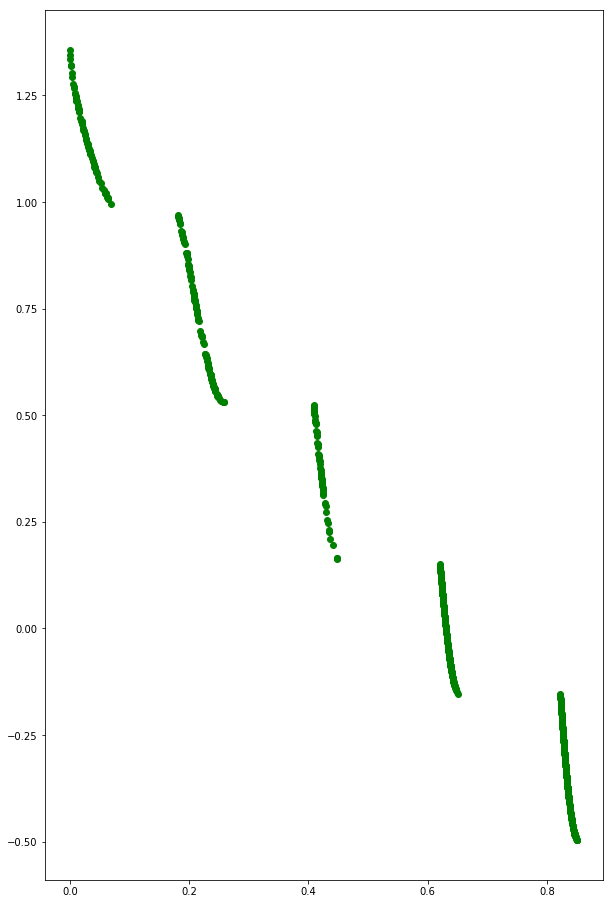

Iteration: 230


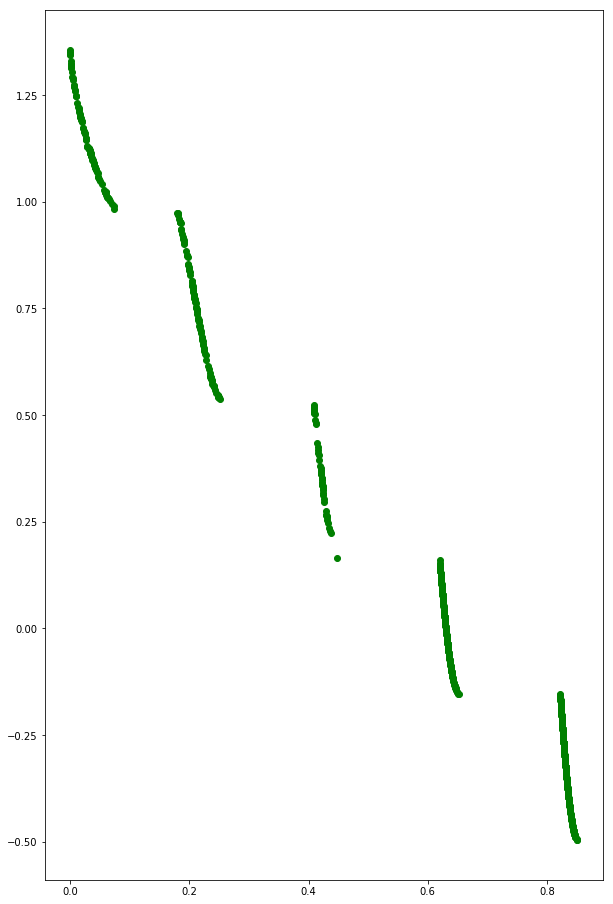

Iteration: 240


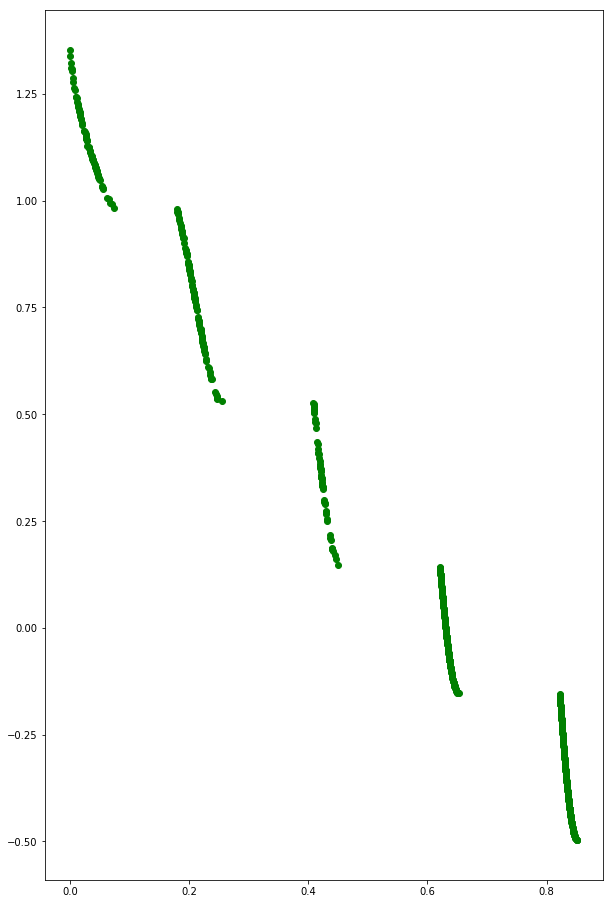

Iteration: 250


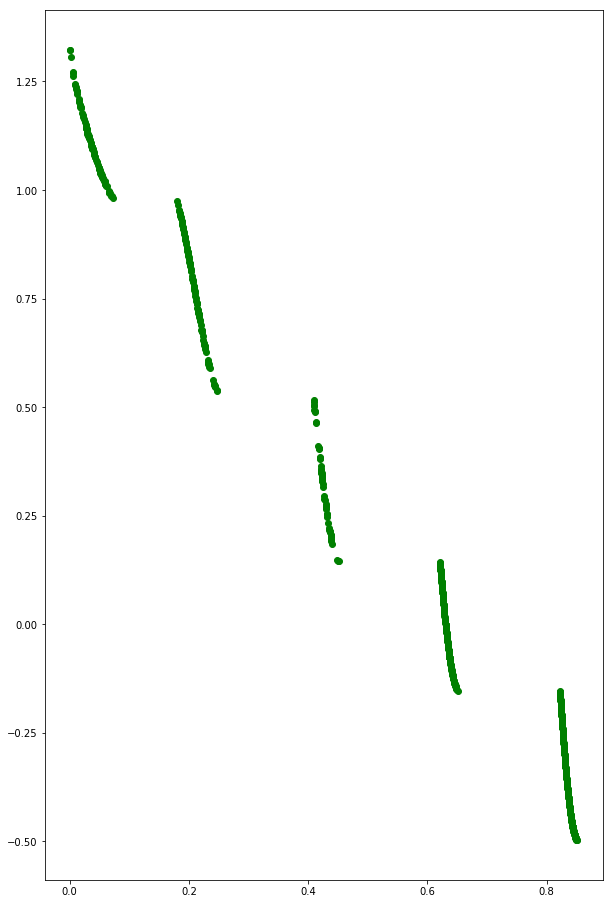

Iteration: 260


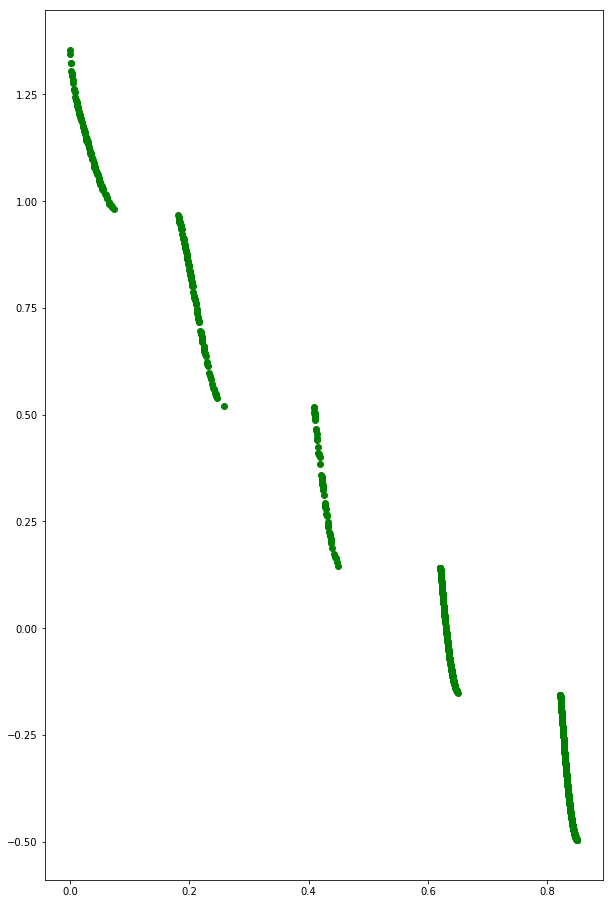

Iteration: 270


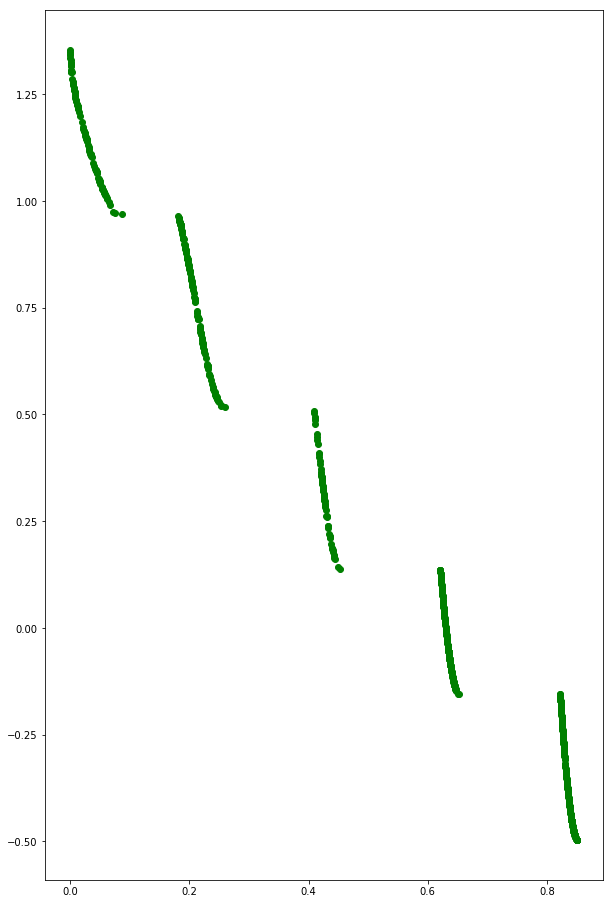

Iteration: 280


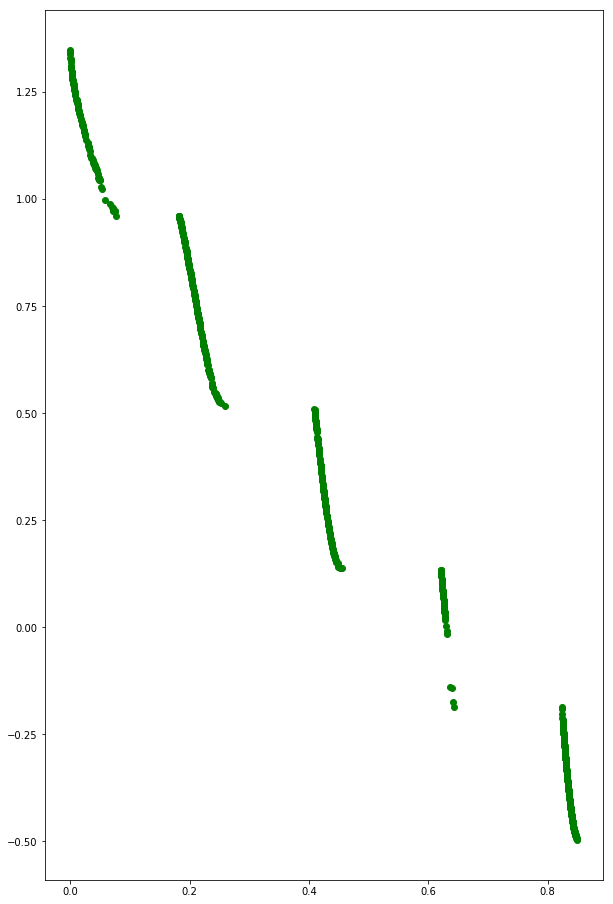

Iteration: 290


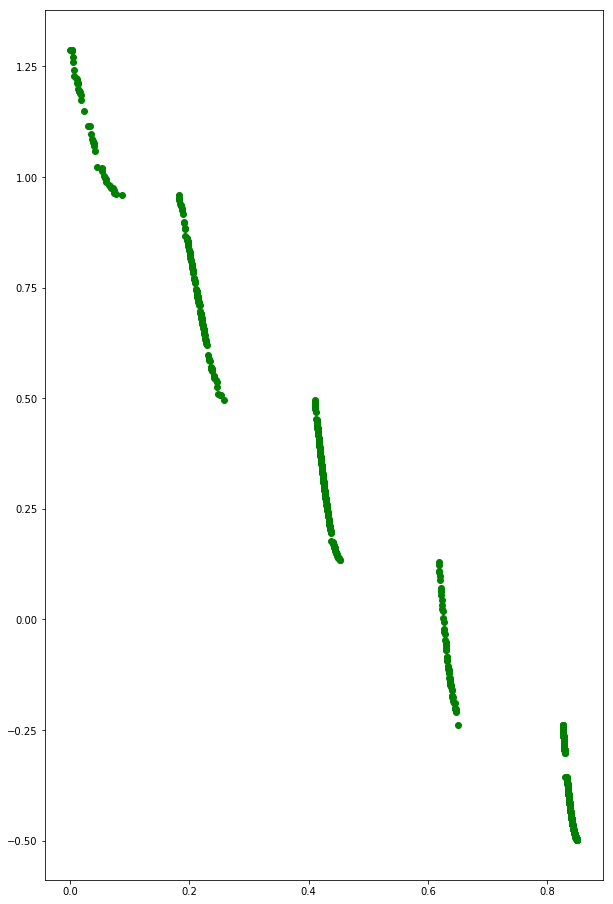

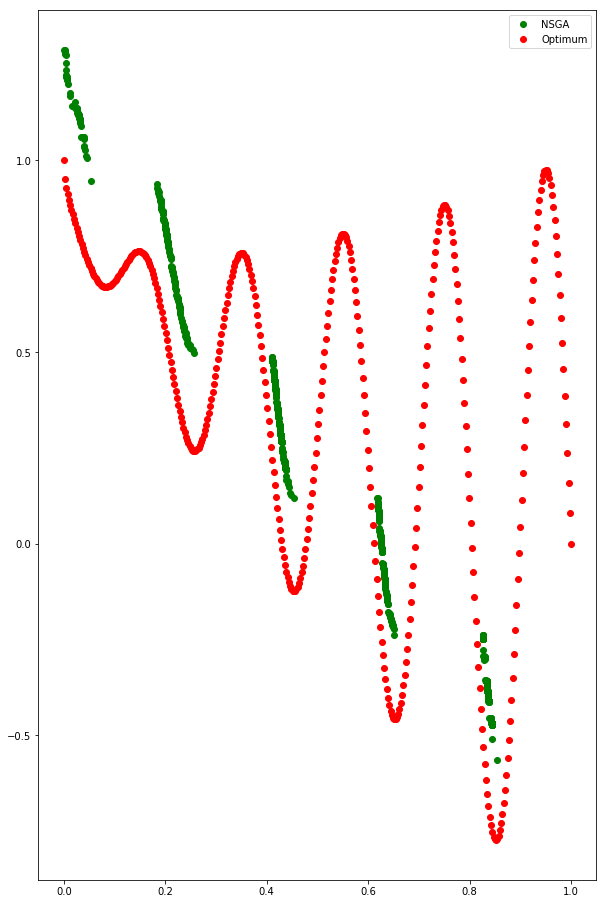

In [270]:
###########
#ZDT3
###########
result = NSGA([ZDT3f1, ZDT3f2], chromosome_length=30, population_size=1000, number_of_iterations=300, number_of_offspring=1000,
       number_of_parents=1, sigma=0.25, tau=0.5, tau_0=0.5, log_frequency=10, min_domain=0.0, max_domain=1.0, mutation_type='no_correl',
      log_function=None)

#print(result)

plt.figure(figsize=(10,16))

optimal_x = np.zeros((400, 30))
optimal_x[:, 0] = np.linspace(0.0, 1.0, 400)
optimal_y = np.array([ZDT3f1(optimal_x), ZDT3f2(optimal_x)])

plt.plot(result[1][0,:], result[1][1,:], 'go', label='NSGA')
plt.plot(optimal_y[0, :], optimal_y[1,:], 'ro', label='Optimum')

plt.legend()

plt.show()

Iteration: 0


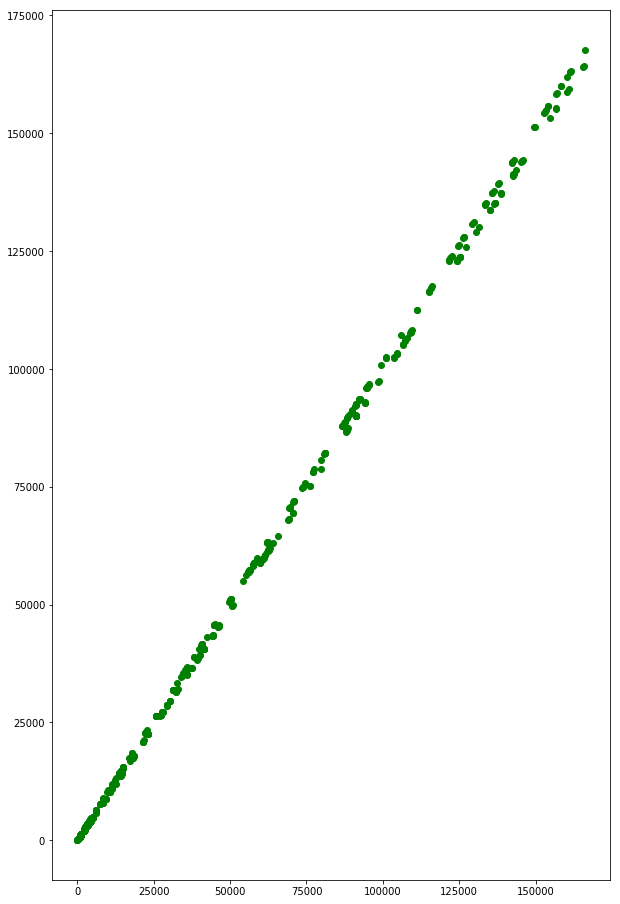

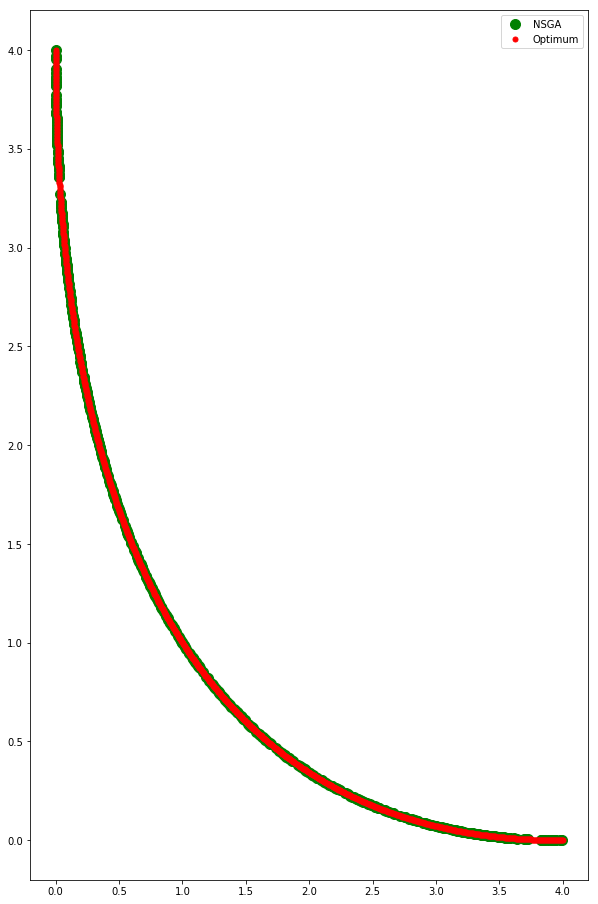

In [284]:
###########
#SCH
###########
result = NSGA([SCHf1, SCHf2], chromosome_length=1, population_size=500, number_of_iterations=10, number_of_offspring=500,
       number_of_parents=1, sigma=0.25, tau=0.5, tau_0=0.5, log_frequency=10, min_domain=-1000.0, max_domain=1000.0, mutation_type='no_correl',
      log_function=None)

#print(result)

plt.figure(figsize=(10,16))

optimal_x = np.zeros((1000, 30))
optimal_x[:, 0] = np.linspace(0.0, 2.0, 1000)
optimal_y = np.array([SCHf1(optimal_x), SCHf2(optimal_x)])

plt.plot(result[1][0,:], result[1][1,:], 'go', label='NSGA', markersize=10)
plt.plot(optimal_y[0, :], optimal_y[1,:], 'ro', label='Optimum', markersize=5)

plt.legend()

plt.show()

Iteration: 0


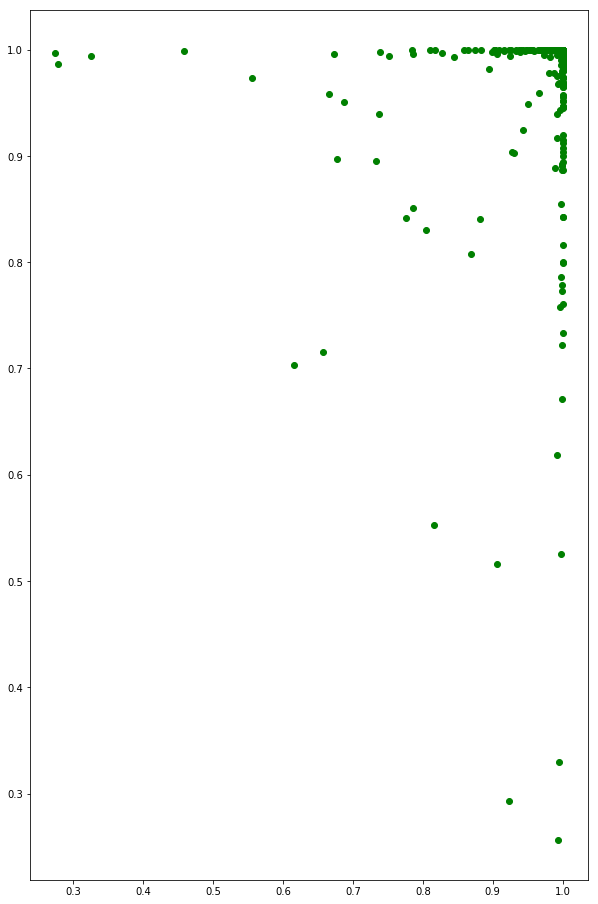

Iteration: 10


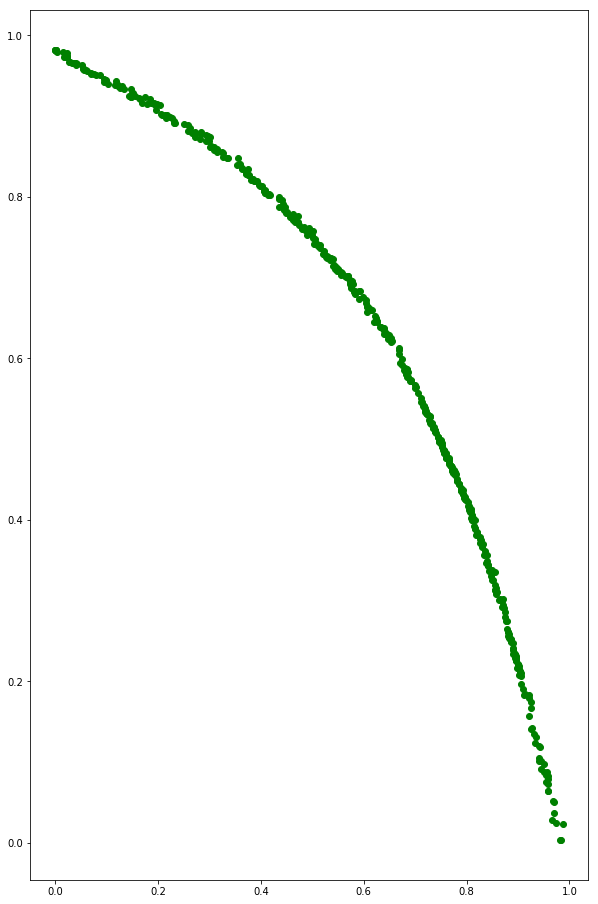

Iteration: 20


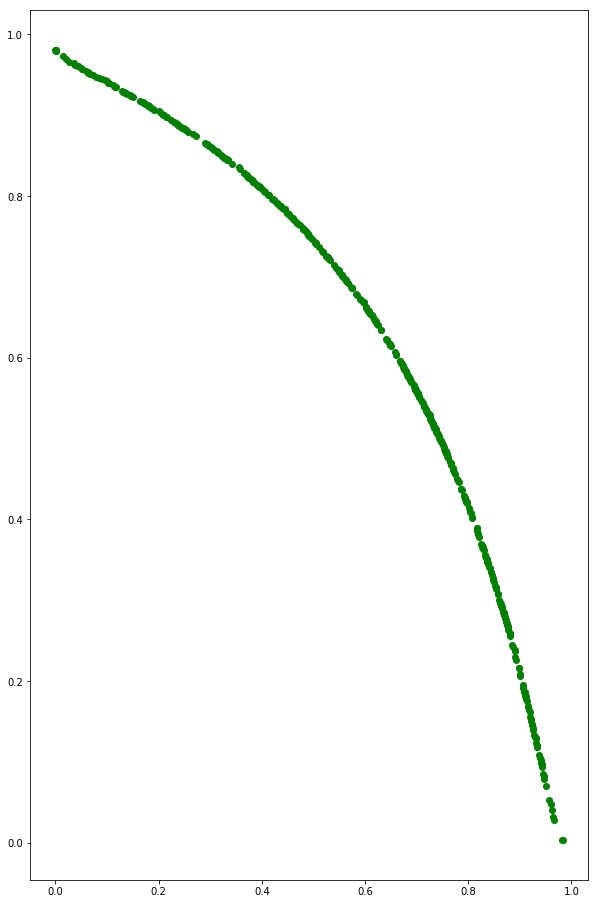

Iteration: 30


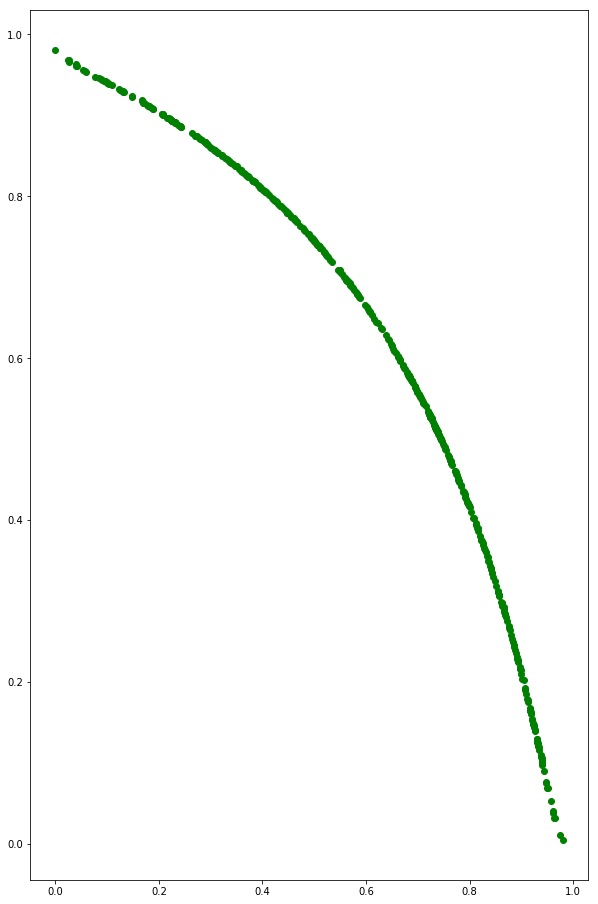

Iteration: 40


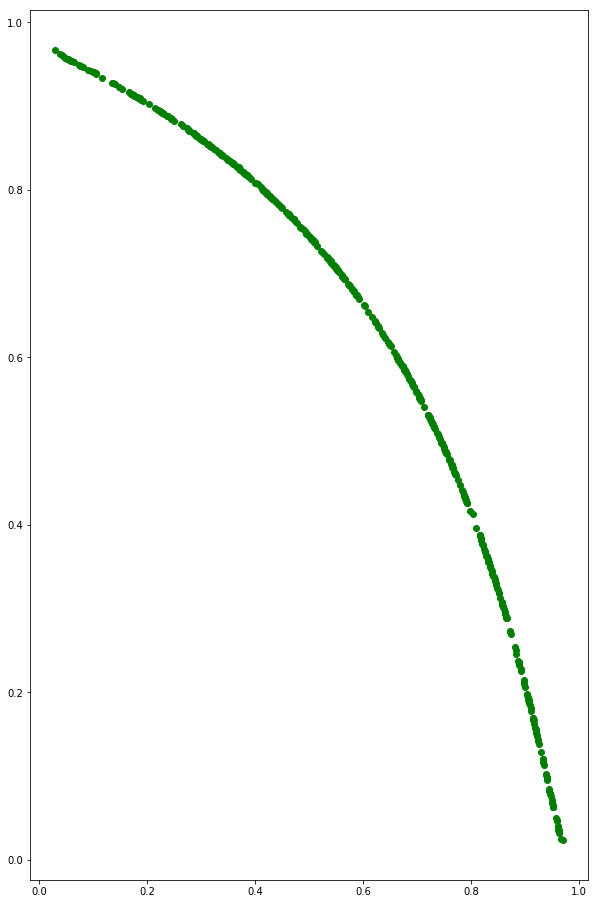

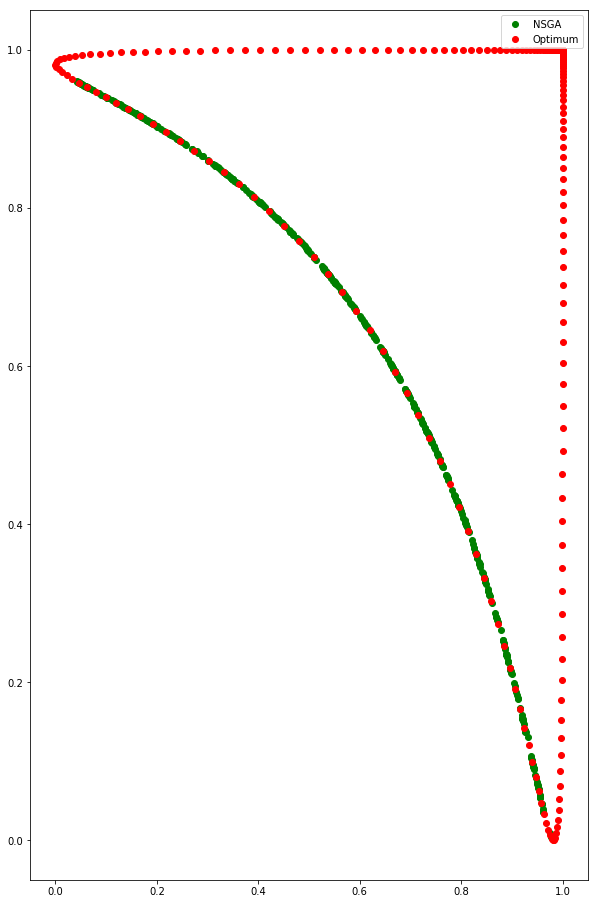

In [286]:
###########
#SCH
###########
result = NSGA([FONf1, FONf2], chromosome_length=3, population_size=500, number_of_iterations=50, number_of_offspring=500,
       number_of_parents=1, sigma=0.25, tau=0.5, tau_0=0.5, log_frequency=10, min_domain=-4.0, max_domain=4.0, mutation_type='no_correl',
      log_function=None)

#print(result)

plt.figure(figsize=(10,16))

optimal_x = np.zeros((400, 3))
optimal_x[:, :] = np.linspace(-4.0, 4.0, 400)[:,None]
optimal_y = np.array([FONf1(optimal_x), FONf2(optimal_x)])

plt.plot(result[1][0,:], result[1][1,:], 'go', label='NSGA')
plt.plot(optimal_y[0, :], optimal_y[1,:], 'ro', label='Optimum')

plt.legend()

plt.show()